In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from openpyxl.styles.builtins import title
from sklearn.metrics.pairwise import cosine_similarity, manhattan_distances, euclidean_distances
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.optimize import curve_fit
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
from itertools import combinations
import yaml
import pandas_datareader.data as web
import os
import re
import requests
import json
from datetime import datetime
from statsmodels.tsa.stattools import adfuller, kpss
from scipy import stats
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

## Autocorrelation Analysis of Bond Yields

The goal of this analysis is to find the autocorrelation patterns in bond yields over different time lags. We will use the daily yield data of various US Treasury bonds and analyze their autocorrelation functions (ACF) to identify significant lags that can be used for predictive modeling.

Use both partial and full autocorrelation functions to identify significant lags.

In [15]:
# load in the dataset
# data_bonds = pd.read_parquet('./training_data_diff.parquet')
# keep only the bond yield columns
dependent_varaibles = [
    'DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30'
]

# independent_variables = [col for col in data_bonds.columns if col not in dependent_varaibles]


In [5]:
# data_bonds.head()

In [4]:
# get the autocorrelation function for each bond yield
# for bond in dependent_varaibles:
#     plt.figure(figsize=(12, 6))
#     plt.suptitle(f'Autocorrelation Analysis for {bond}', fontsize=16)
#
#     plt.subplot(1, 2, 1)
#     plot_acf(data_bonds[bond].dropna(), lags=50, ax=plt.gca())
#     plt.title('Autocorrelation Function (ACF)')
#
#     plt.subplot(1, 2, 2)
#     plot_pacf(data_bonds[bond].dropna(), lags=50, ax=plt.gca(), method='ywm')
#     plt.title('Partial Autocorrelation Function (PACF)')
#
#     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#     plt.show()

In [16]:
bond_yields = pd.read_parquet('data/fred_prorcessed_daily.parquet')
bond_yields = bond_yields[dependent_varaibles]
# get the index values from the data_bonds dataframe
bond_yields_train = bond_yields[bond_yields.index.to_timestamp() < pd.Timestamp('2020-01-01')]
bond_yields_test = bond_yields[bond_yields.index.to_timestamp() >= pd.Timestamp('2020-01-01')]

print("Training set time period:", bond_yields_train.index.min(), "to", bond_yields_train.index.max())
print("Testing set time period:", bond_yields_test.index.min(), "to", bond_yields_test.index.max())
print(bond_yields_train.shape)

Training set time period: 1960-01-01 to 2019-12-31
Testing set time period: 2020-01-01 to 2024-12-31
(21915, 11)


In [ ]:
# for bond in dependent_varaibles:
#     plt.figure(figsize=(12, 6))
#     plt.suptitle(f'Autocorrelation Analysis for {bond}', fontsize=16)
#
#     plt.subplot(1, 2, 1)
#     plot_acf(bond_yields_train[bond].dropna(), lags=60, ax=plt.gca())
#     plt.title('Autocorrelation Function (ACF)')
#
#     plt.subplot(1, 2, 2)
#     plot_pacf(bond_yields_train[bond].dropna(), lags=60, ax=plt.gca(), method='ywm')
#     plt.title('Partial Autocorrelation Function (PACF)')
#
#     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#     plt.show()

In [17]:
bond_yields_train = bond_yields[bond_yields.index.to_timestamp() >= pd.Timestamp('2011-01-01')]
# bond_yields_train.head()
bond_yields_train.isna().sum() / bond_yields_train.shape[0]

DGS1MO    0.0
DGS3MO    0.0
DGS6MO    0.0
DGS1      0.0
DGS2      0.0
DGS3      0.0
DGS5      0.0
DGS7      0.0
DGS10     0.0
DGS20     0.0
DGS30     0.0
dtype: float64

In [16]:
# pick 5 random indexes from the training set
# random_indexes = np.random.choice(bond_yields_train.index, size=6, replace=False)
# random_indexes
random_indexes2 = ['2015-06-15', '2016-09-20', '2017-12-25', '2018-03-30', '2019-07-04', '2019-11-11']

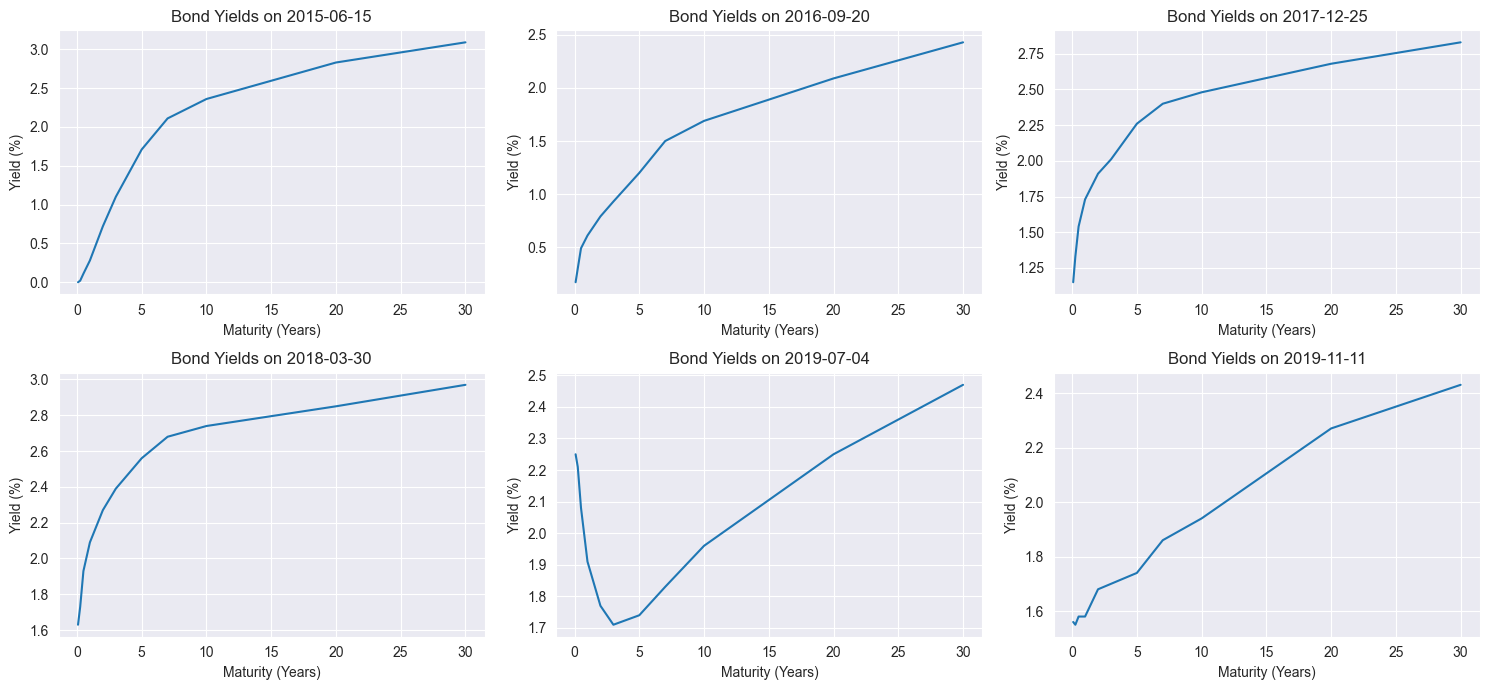

In [17]:
# plot the random indexes
x_labels = [round(1/12, 3), 1/4, 1/2, 1, 2, 3, 5, 7, 10, 20, 30]

# create a 3 by 3 subplot
fig, axes = plt.subplots(2, 3, figsize=(15, 7))
axes = axes.flatten()
for i, idx in enumerate(random_indexes2):
    # create a line plot for each bond yield
    y_values = bond_yields_train.loc[idx].values
    sns.lineplot(x=x_labels, y=y_values, ax=axes[i])
    axes[i].set_title(f'Bond Yields on {idx}')
    axes[i].set_xlabel('Maturity (Years)')
    axes[i].set_ylabel('Yield (%)')

plt.tight_layout()
plt.show()

In [18]:
# Create features for the yield curves
def nelson_siegel(maturity, beta0, beta1, beta2, lambda_):
        return (beta0 +
                beta1 * ((1 - np.exp(-lambda_ * maturity)) / (lambda_ * maturity)) +
                beta2 * (((1 - np.exp(-lambda_ * maturity)) / (lambda_ * maturity)) - np.exp(-lambda_ * maturity)))


def nelson_siegel_params(yields, maturities):
    """
    Fit the Nelson-Siegel model to the yield curve data and return the parameters.
    Yields: array-like, bond yields
    Maturities: array-like, bond maturities in years
    """
    # Initial guess for the parameters
    initial_guess = [0.03, -0.02, 0.02, 0.5]
    # Fit the model
    params, _ = curve_fit(nelson_siegel, maturities, yields, p0=initial_guess)
    return params

In [19]:
maturieties = [round(1/12, 3), 1/4, 1/2, 1, 2, 3, 5, 7, 10, 20, 30]
yields = bond_yields_train.loc['2015-06-15'].values / 100
ns_params = nelson_siegel_params(yields, maturieties)

# make the predictions
predicted_yields = nelson_siegel(np.array(maturieties), *ns_params)
print(type(ns_params))
ns_params

<class 'numpy.ndarray'>


array([ 0.03320718, -0.03359343, -0.02637269,  0.67184961])

In [20]:
predicted_yields = predicted_yields * 100
yields = yields * 100
# plot the actual vs predicted yields
df_predicted = pd.DataFrame({
    'Maturity': maturieties,
    'Actual Yields': yields,
    'Predicted Yields': predicted_yields
})
df_predicted

Maturity  Actual Yields  Predicted Yields
0      0.083           0.00         -0.017532
1      0.250           0.02          0.030168
2      0.500           0.11          0.112194
3      1.000           0.28          0.301040
4      2.000           0.72          0.710203
5      3.000           1.10          1.093386
6      5.000           1.71          1.689341
7      7.000           2.11          2.081122
8     10.000           2.36          2.432431
9     20.000           2.83          2.874446
10    30.000           3.09          3.023201

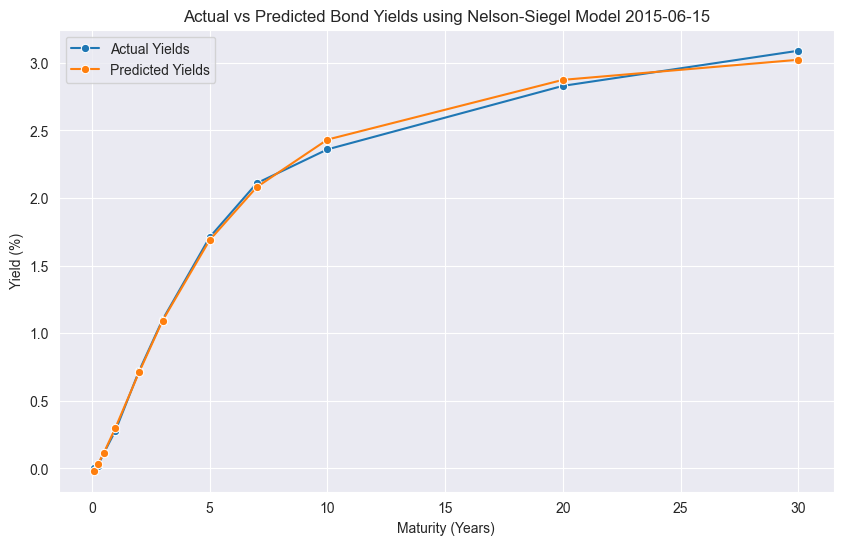

In [21]:
# melt the data for plotting
df_melted = df_predicted.melt(id_vars='Maturity', value_vars=['Actual Yields', 'Predicted Yields'], var_name='Type', value_name='Yield')

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_melted, x='Maturity', y='Yield', hue='Type', marker='o')
plt.title('Actual vs Predicted Bond Yields using Nelson-Siegel Model 2015-06-15')
plt.xlabel('Maturity (Years)')
plt.ylabel('Yield (%)')
plt.legend()
plt.show()

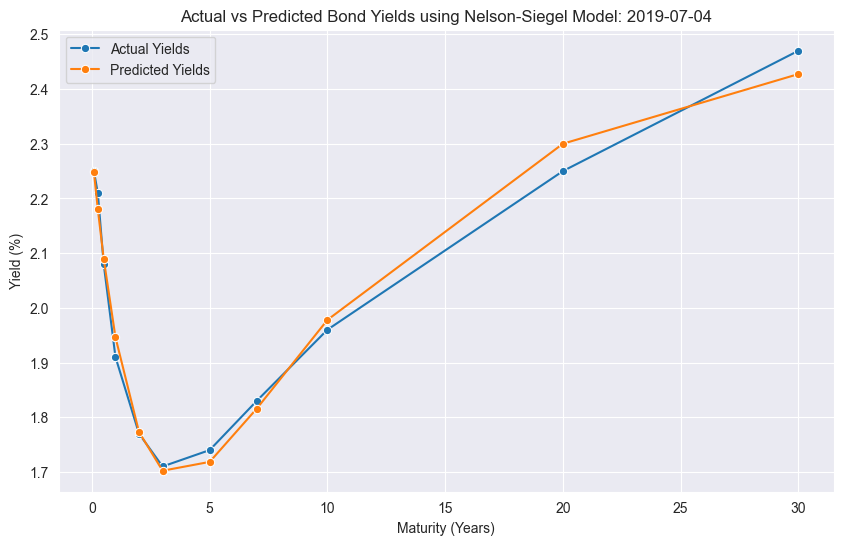

In [22]:
yields = bond_yields_train.loc['2019-07-04'].values / 100
ns_params = nelson_siegel_params(yields, maturieties)
# make the predictions
predicted_yields = nelson_siegel(np.array(maturieties), *ns_params)

predicted_yields = predicted_yields * 100
yields = yields * 100
# plot the actual vs predicted yields
df_predicted = pd.DataFrame({
    'Maturity': maturieties,
    'Actual Yields': yields,
    'Predicted Yields': predicted_yields
})

# melt the data for plotting
df_melted = df_predicted.melt(id_vars='Maturity', value_vars=['Actual Yields', 'Predicted Yields'], var_name='Type',
                              value_name='Yield')

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_melted, x='Maturity', y='Yield', hue='Type', marker='o')
plt.title('Actual vs Predicted Bond Yields using Nelson-Siegel Model: 2019-07-04')
plt.xlabel('Maturity (Years)')
plt.ylabel('Yield (%)')
plt.legend()
plt.show()

In [23]:
# model the entire training set using the nelson_siegel_params function by applying it to each row
ns_param_columns = ['beta0', 'beta1', 'beta2', 'lambda']
bond_yields_train = bond_yields_train.dropna()
bond_yields_ns_params = bond_yields_train.apply(lambda row: pd.Series(nelson_siegel_params(row.values / 100, maturieties), index=ns_param_columns), axis=1)
bond_yields_ns_params.head()
# bond_yields_train.isna().sum() / bond_yields_train.shape[0]

beta0     beta1     beta2    lambda
period                                            
2011-01-01  0.049463 -0.047990 -0.054737  0.611760
2011-01-02  0.049463 -0.047990 -0.054737  0.611760
2011-01-03  0.050050 -0.048164 -0.057179  0.622251
2011-01-04  0.050643 -0.048853 -0.056699  0.603432
2011-01-05  0.051663 -0.049933 -0.056482  0.622837

<Axes: >

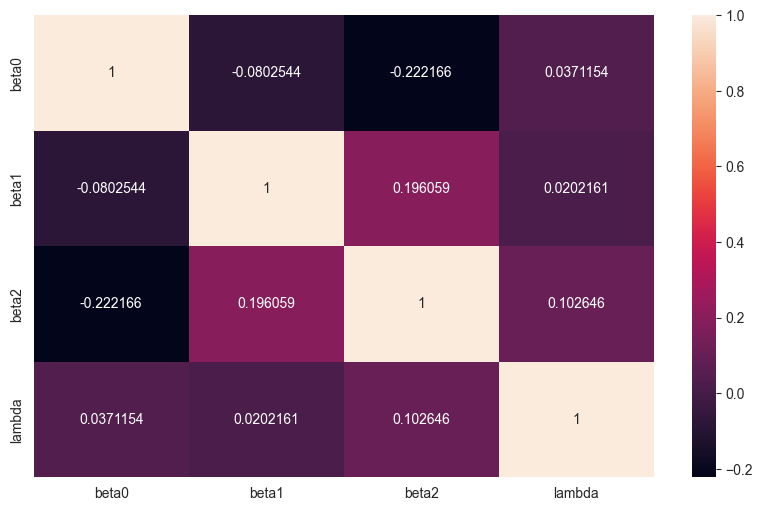

In [25]:
# get the correlation matrix of the coefficients
ns_corr = bond_yields_ns_params.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(data=ns_corr, annot=True, fmt='g')



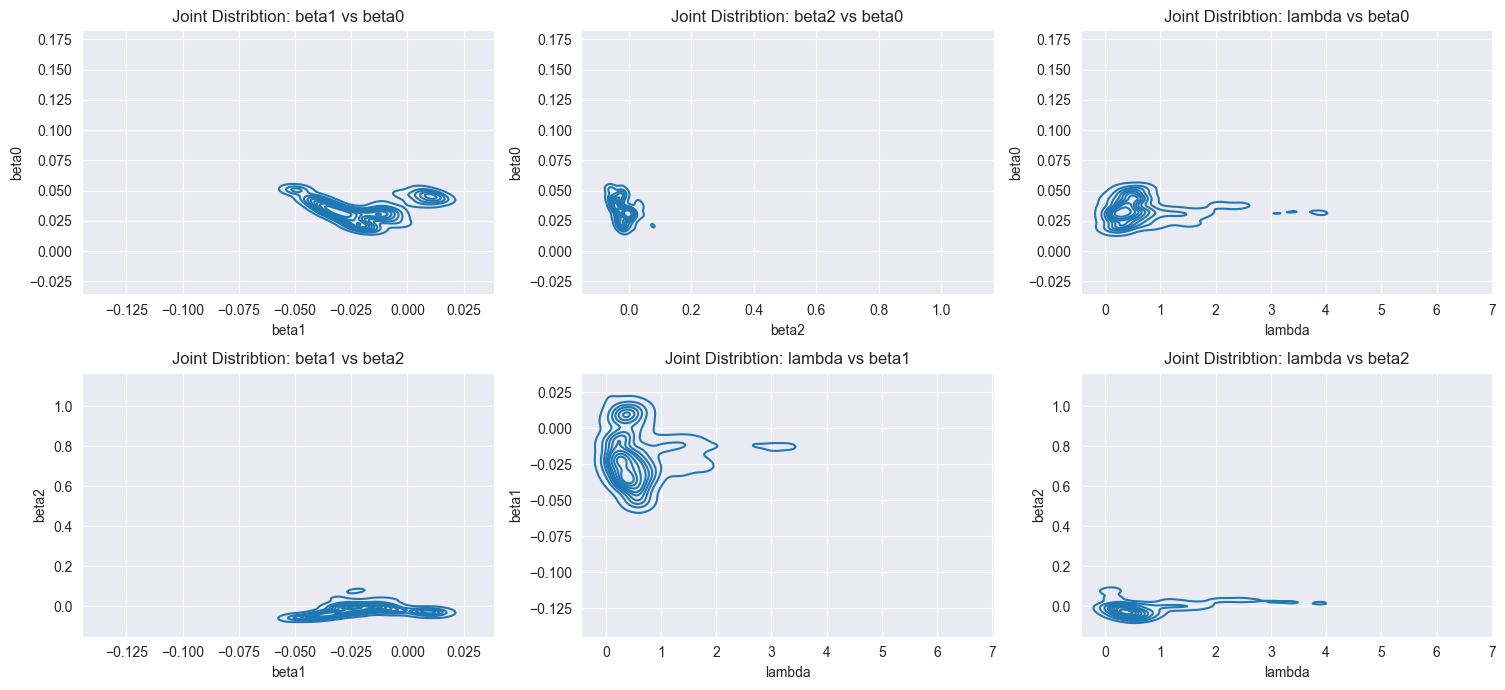

In [26]:
# get the joint distribution of the coefficients
joint_dist = [
    ['beta1', 'beta0'],
    ['beta2', 'beta0'],
    ['lambda', 'beta0'],
    ['beta1', 'beta2'],
    ['lambda', 'beta1'],
    ['lambda', 'beta2'],
]

# create a 2 by 3 subplot and plot the joint distribution between the mentioned variables in join_dist list
fig, axes = plt.subplots(2, 3, figsize=(15, 7))
axes = axes.flatten()
for i, vals in enumerate(joint_dist):
    # create a line plot for each bond yield
    sns.kdeplot(bond_yields_ns_params, x=vals[0], y=vals[1], ax=axes[i])
    axes[i].set_title(f'Joint Distribution: {vals[0]} vs {vals[1]}')
    axes[i].set_xlabel(f'{vals[0]}')
    axes[i].set_ylabel(f'{vals[1]}')

plt.tight_layout()
plt.show()

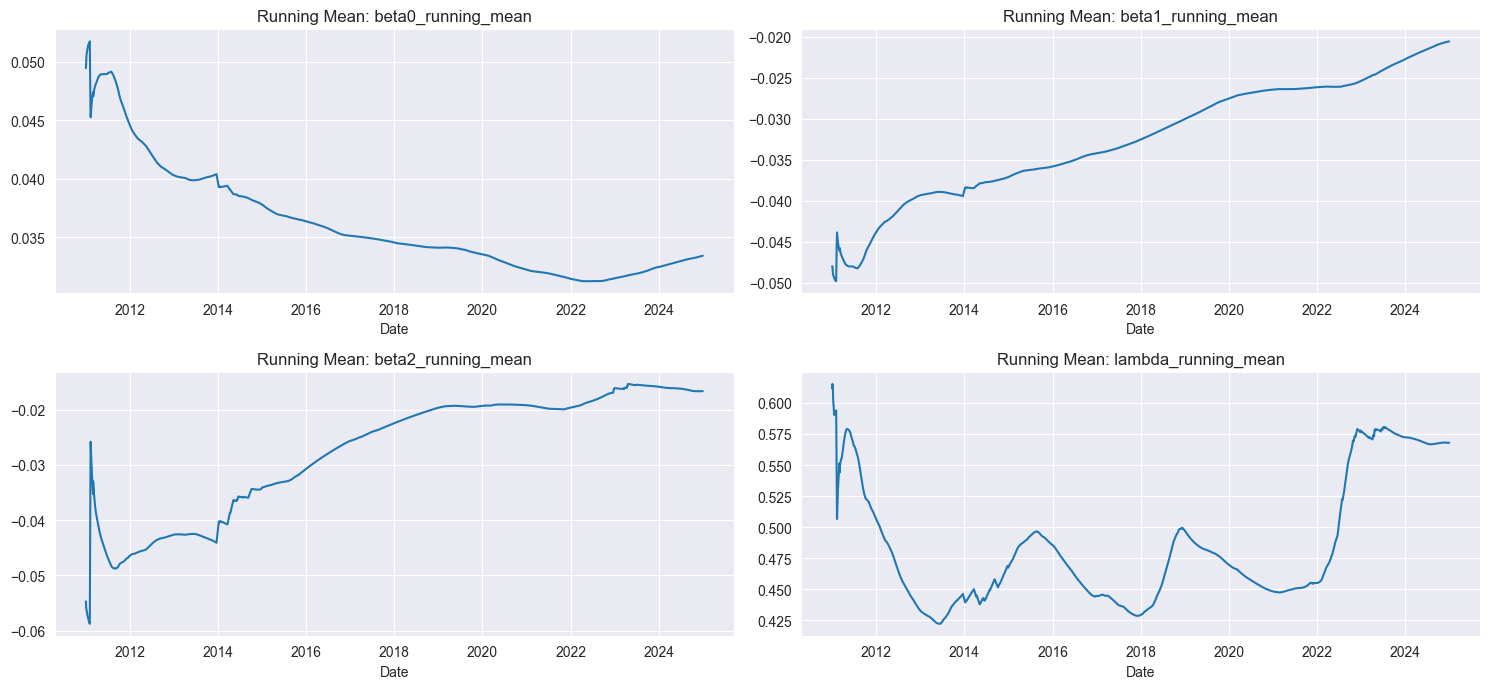

In [24]:
# calculate the cumulative mean for each coefficient
for col in bond_yields_ns_params.columns:
    bond_yields_ns_params[f"{col}_running_mean"] = bond_yields_ns_params[col].expanding().mean()
# get the columns with running mean
running_mean_cols = [x for x in bond_yields_ns_params.columns if "_running_mean" in x]
xlabels = [x.to_timestamp() for x in bond_yields_ns_params.index]

 # create a 2 by 2 subplot and plot a line plot of each running mean
fig, axes = plt.subplots(2, 2, figsize=(15, 7))
axes = axes.flatten()

for i, col in enumerate(running_mean_cols):
    # create a line plot for each bond yield
    sns.lineplot(bond_yields_ns_params, x=xlabels, y=col, ax=axes[i])
    axes[i].set_title(f'Running Mean: {col}')
    axes[i].set_xlabel(f'Date')
    axes[i].set_ylabel(f'')

plt.tight_layout()
plt.show()

In [26]:
# create predictions using the nelson_siegel function for each row
bond_yields_ns_predictions = bond_yields_ns_params[ns_param_columns].apply(lambda row: nelson_siegel(np.array(maturieties), *row.values), axis=1)
bond_yields_ns_predictions = bond_yields_ns_predictions.apply(lambda x: x * 100)
bond_yields_ns_predictions = pd.DataFrame(bond_yields_ns_predictions.tolist(), index=bond_yields_ns_predictions.index, columns=[f'{maturity}' for maturity in dependent_varaibles])
# round each column to 2 decimal places
for col in bond_yields_ns_predictions.columns:
    bond_yields_ns_predictions[col] = bond_yields_ns_predictions[col].round(2)
bond_yields_ns_predictions.head()

DGS1MO  DGS3MO  DGS6MO  DGS1  DGS2  DGS3  DGS5  DGS7  DGS10  \
period                                                                    
2011-01-01    0.13    0.12    0.13  0.23  0.63  1.12  2.00  2.66   3.28   
2011-01-02    0.13    0.12    0.13  0.23  0.63  1.12  2.00  2.66   3.28   
2011-01-03    0.17    0.14    0.14  0.23  0.63  1.12  2.02  2.69   3.33   
2011-01-04    0.16    0.14    0.15  0.24  0.63  1.12  2.01  2.69   3.33   
2011-01-05    0.16    0.15    0.16  0.28  0.71  1.22  2.15  2.83   3.47   

            DGS20  DGS30  
period                    
2011-01-01   4.11   4.39  
2011-01-02   4.11   4.39  
2011-01-03   4.16   4.44  
2011-01-04   4.19   4.48  
2011-01-05   4.31   4.60

In [ ]:
bond_yields_train.head()

In [16]:
# perform point wise subtraction between bond_yields_train and bond_yields_ns_predictions
bond_yields_residuals = bond_yields_train.to_numpy() - bond_yields_ns_predictions.to_numpy()
bond_yields_residuals = pd.DataFrame(bond_yields_residuals, index=bond_yields_train.index, columns=bond_yields_train.columns)
bond_yields_residuals.head()

DGS1MO  DGS3MO  DGS6MO  DGS1  DGS2  DGS3  DGS5  DGS7  DGS10  \
period                                                                    
2011-01-01   -0.06    0.00    0.06  0.06 -0.02 -0.10  0.01  0.05   0.02   
2011-01-02   -0.06    0.00    0.06  0.06 -0.02 -0.10  0.01  0.05   0.02   
2011-01-03   -0.06    0.01    0.05  0.06 -0.02 -0.09  0.00  0.05   0.03   
2011-01-04   -0.04    0.00    0.04  0.04  0.00 -0.08  0.00  0.03   0.03   
2011-01-05   -0.03   -0.01    0.03  0.03  0.00 -0.06 -0.01  0.03   0.03   

            DGS20  DGS30  
period                    
2011-01-01   0.02  -0.05  
2011-01-02   0.02  -0.05  
2011-01-03   0.02  -0.05  
2011-01-04   0.02  -0.04  
2011-01-05   0.03  -0.05

In [17]:
# create a date column for the residuals dataframe and the predictiosn dataframe
bond_yields_residuals['Date'] = bond_yields_residuals.index
bond_yields_ns_predictions['Date'] = bond_yields_ns_predictions.index
# melt the residuals dataframe and the predictions dataframe with the date column as id_vars
bond_yields_residuals_melted = bond_yields_residuals.melt(id_vars='Date', var_name='Maturity', value_name='Residual')
bond_yields_ns_predictions_melted = bond_yields_ns_predictions.melt(id_vars='Date', var_name='Maturity', value_name='Predicted_Yield')
# join the two dataframes on the date and maturity columns
bond_yields_combined = bond_yields_residuals_melted.merge(bond_yields_ns_predictions_melted, left_on=['Date', 'Maturity'], right_on=['Date', 'Maturity'], how='inner', suffixes=('', ''))
bond_yields_combined.head()

Date Maturity  Residual  Predicted_Yield
0  2011-01-01   DGS1MO     -0.06             0.13
1  2011-01-02   DGS1MO     -0.06             0.13
2  2011-01-03   DGS1MO     -0.06             0.17
3  2011-01-04   DGS1MO     -0.04             0.16
4  2011-01-05   DGS1MO     -0.03             0.16

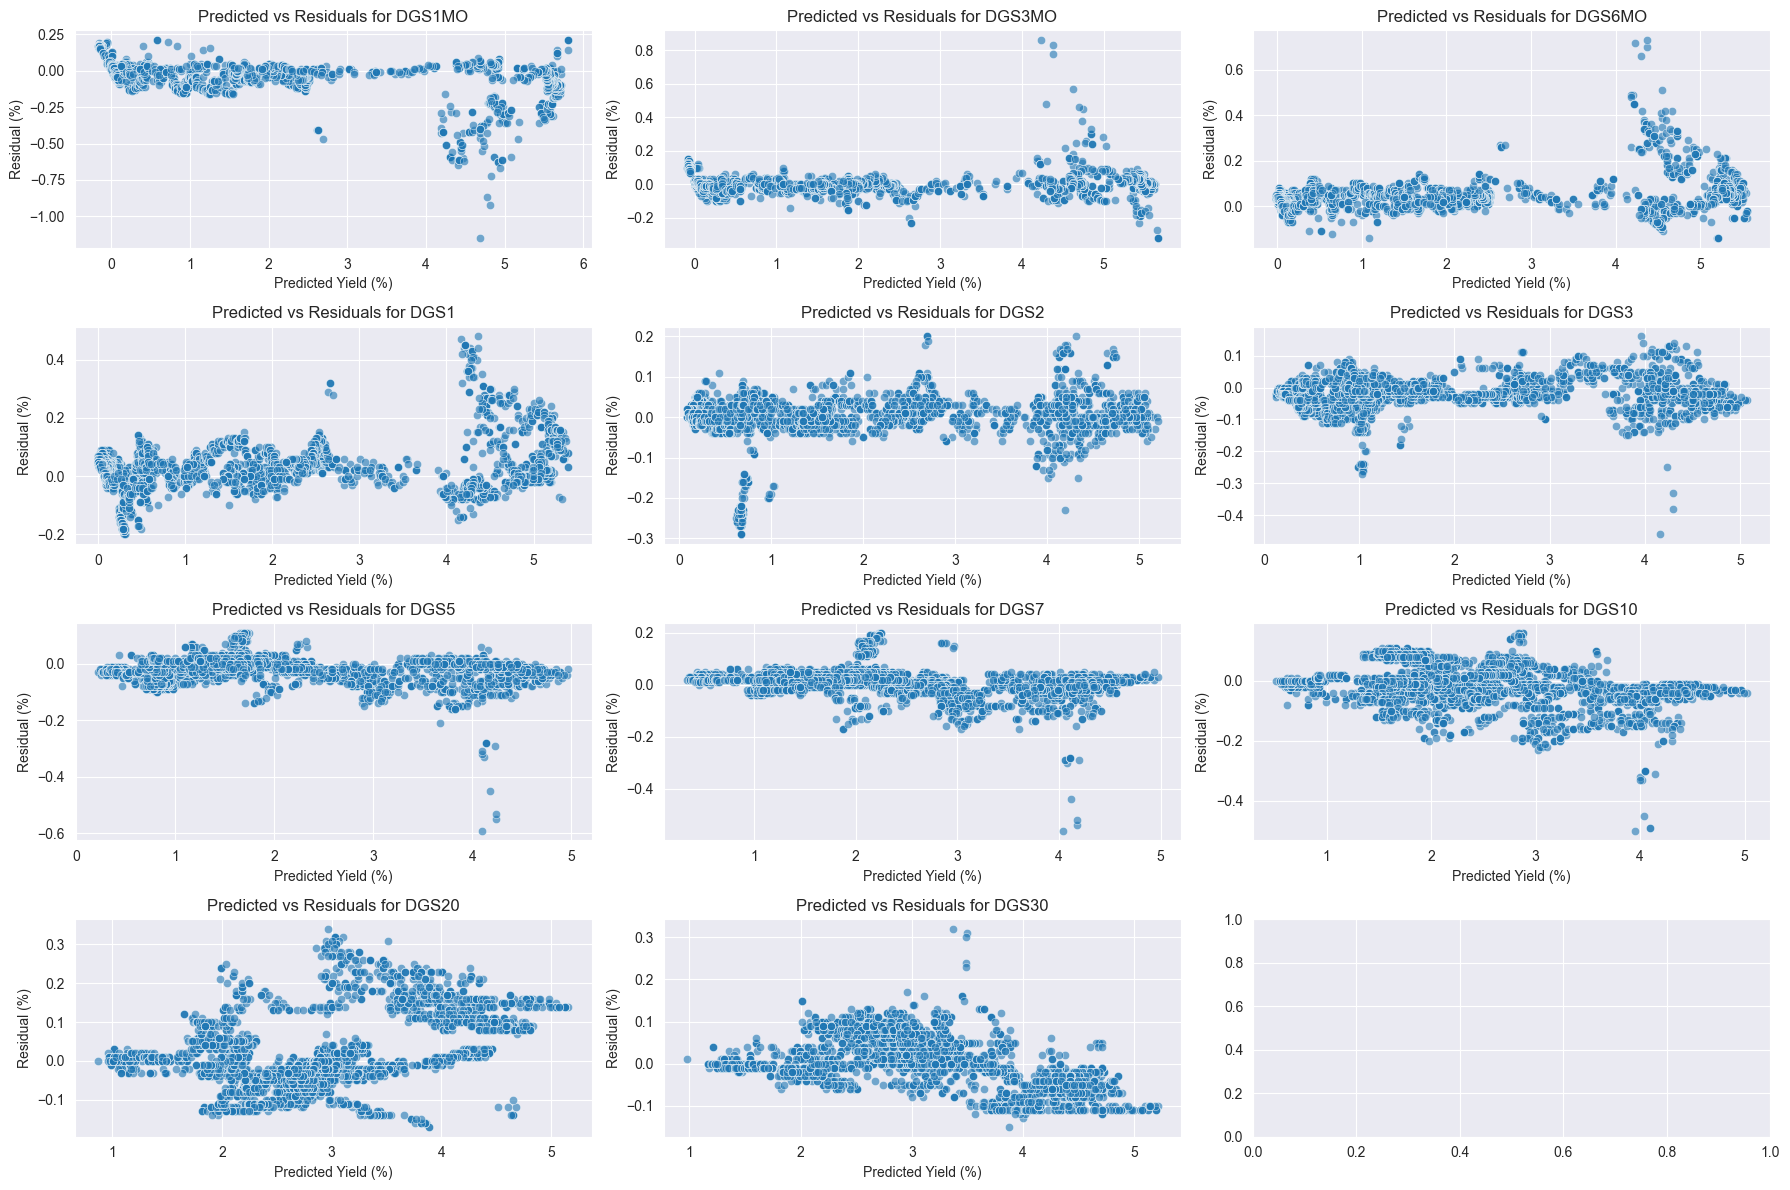

In [18]:
# plot the predicted yields vs the residuals
fig, axes = plt.subplots(4, 3, figsize=(18, 12))
axes = axes.flatten()
# plt.figure(figsize=(12, 6))
for i, maturity in enumerate(dependent_varaibles):
    sns.scatterplot(data=bond_yields_combined[bond_yields_combined['Maturity'] == maturity], x='Predicted_Yield', y='Residual', ax=axes[i], alpha=0.6)
    axes[i].set_title(f'Predicted vs Residuals for {maturity}')
    axes[i].set_xlabel('Predicted Yield (%)')
    axes[i].set_ylabel('Residual (%)')
plt.tight_layout()


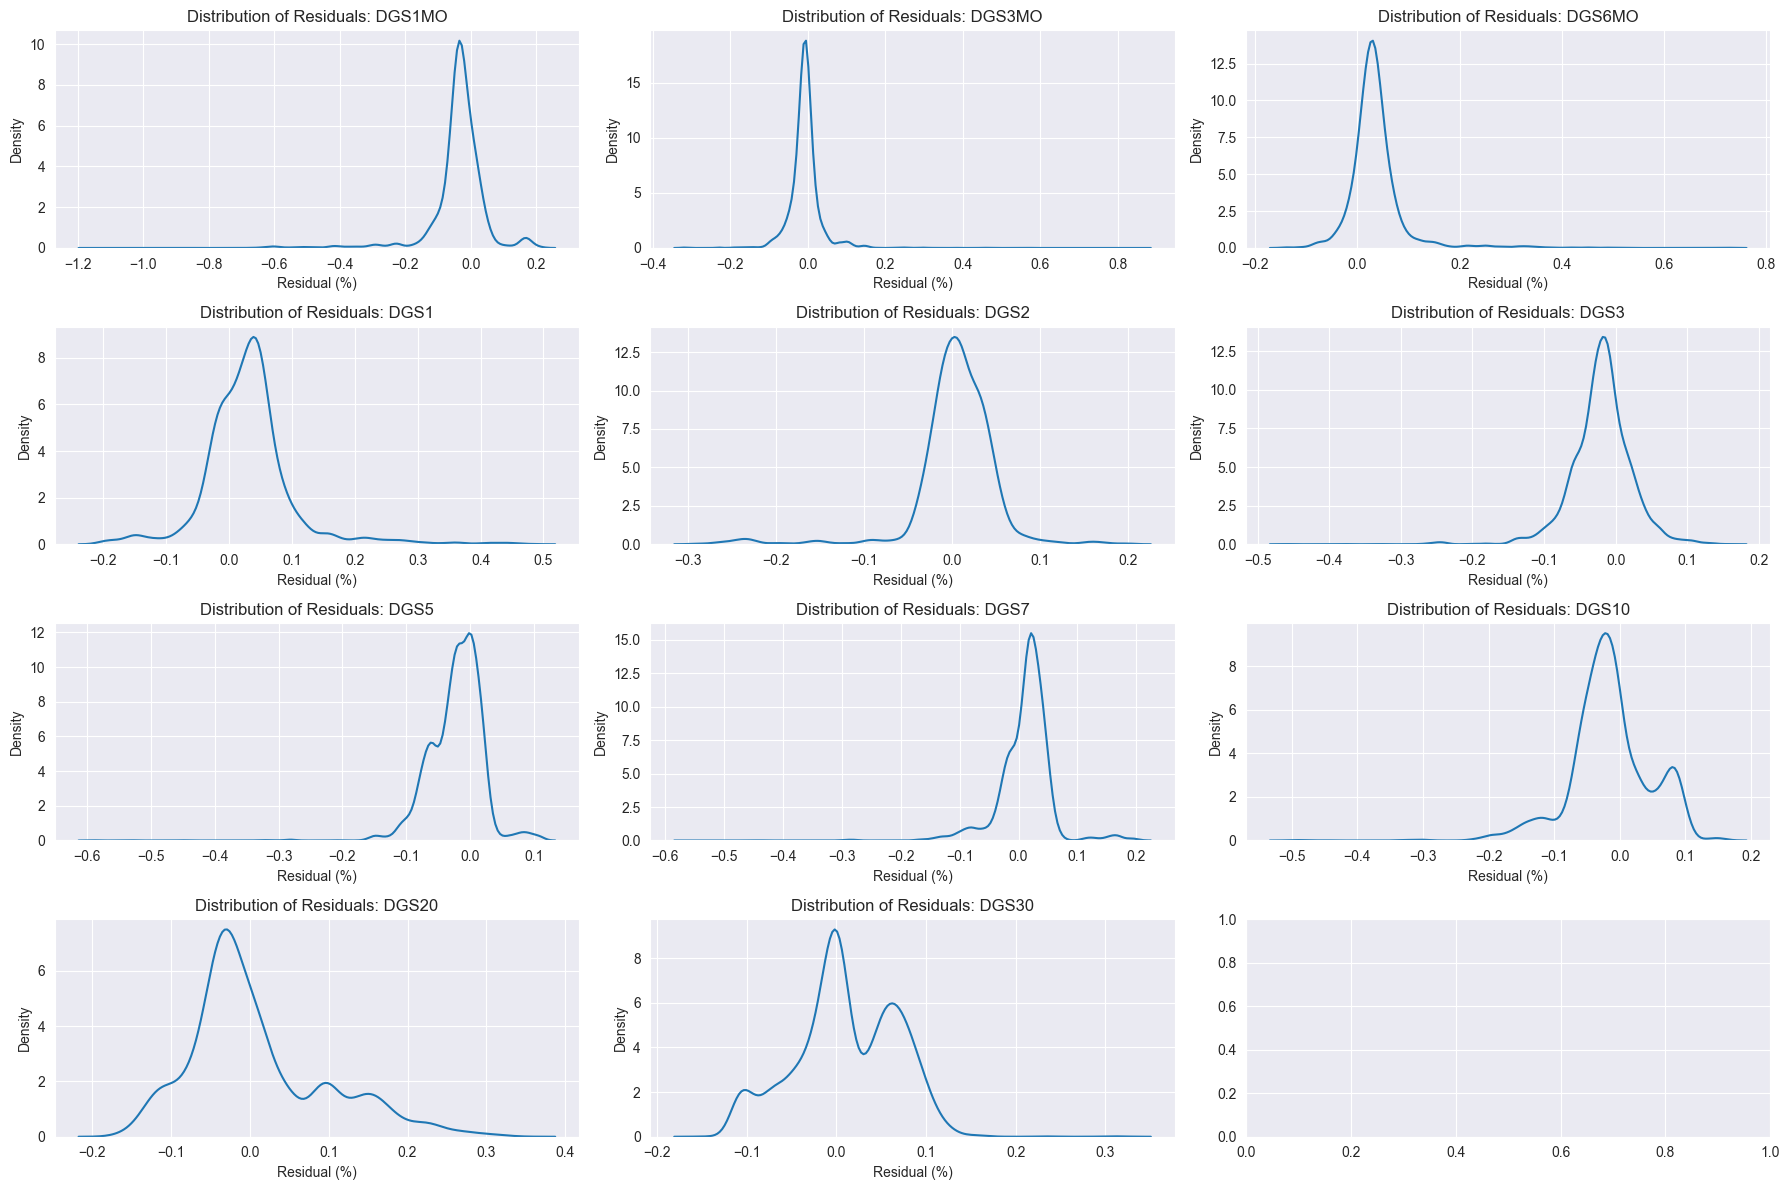

In [19]:
# plot the distribution of the residuals for each maturity
fig, axes = plt.subplots(4, 3, figsize=(18, 12))
axes = axes.flatten()
for i, maturity in enumerate(dependent_varaibles):
    sns.kdeplot(bond_yields_combined[bond_yields_combined['Maturity'] == maturity], x='Residual', ax=axes[i])
    axes[i].set_title(f'Distribution of Residuals: {maturity}')
    axes[i].set_xlabel('Residual (%)')
    axes[i].set_ylabel('Density')
# plt.legend(title='Maturity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [20]:
bond_yields_actuals = bond_yields_train.copy()
bond_yields_actuals['Date'] = bond_yields_actuals.index
# melt the residuals dataframe and the predictions dataframe with the date column as id_vars
bond_yields_actuals_melted = bond_yields_actuals.melt(id_vars='Date', var_name='Maturity', value_name='Actuals')
# join the two dataframes on the date and maturity columns
bond_yields_combined_actuals = bond_yields_actuals_melted.merge(bond_yields_ns_predictions_melted, left_on=['Date', 'Maturity'], right_on=['Date', 'Maturity'], how='inner', suffixes=('', ''))
bond_yields_combined_actuals.head()

Date Maturity  Actuals  Predicted_Yield
0  2011-01-01   DGS1MO     0.07             0.13
1  2011-01-02   DGS1MO     0.07             0.13
2  2011-01-03   DGS1MO     0.11             0.17
3  2011-01-04   DGS1MO     0.12             0.16
4  2011-01-05   DGS1MO     0.13             0.16

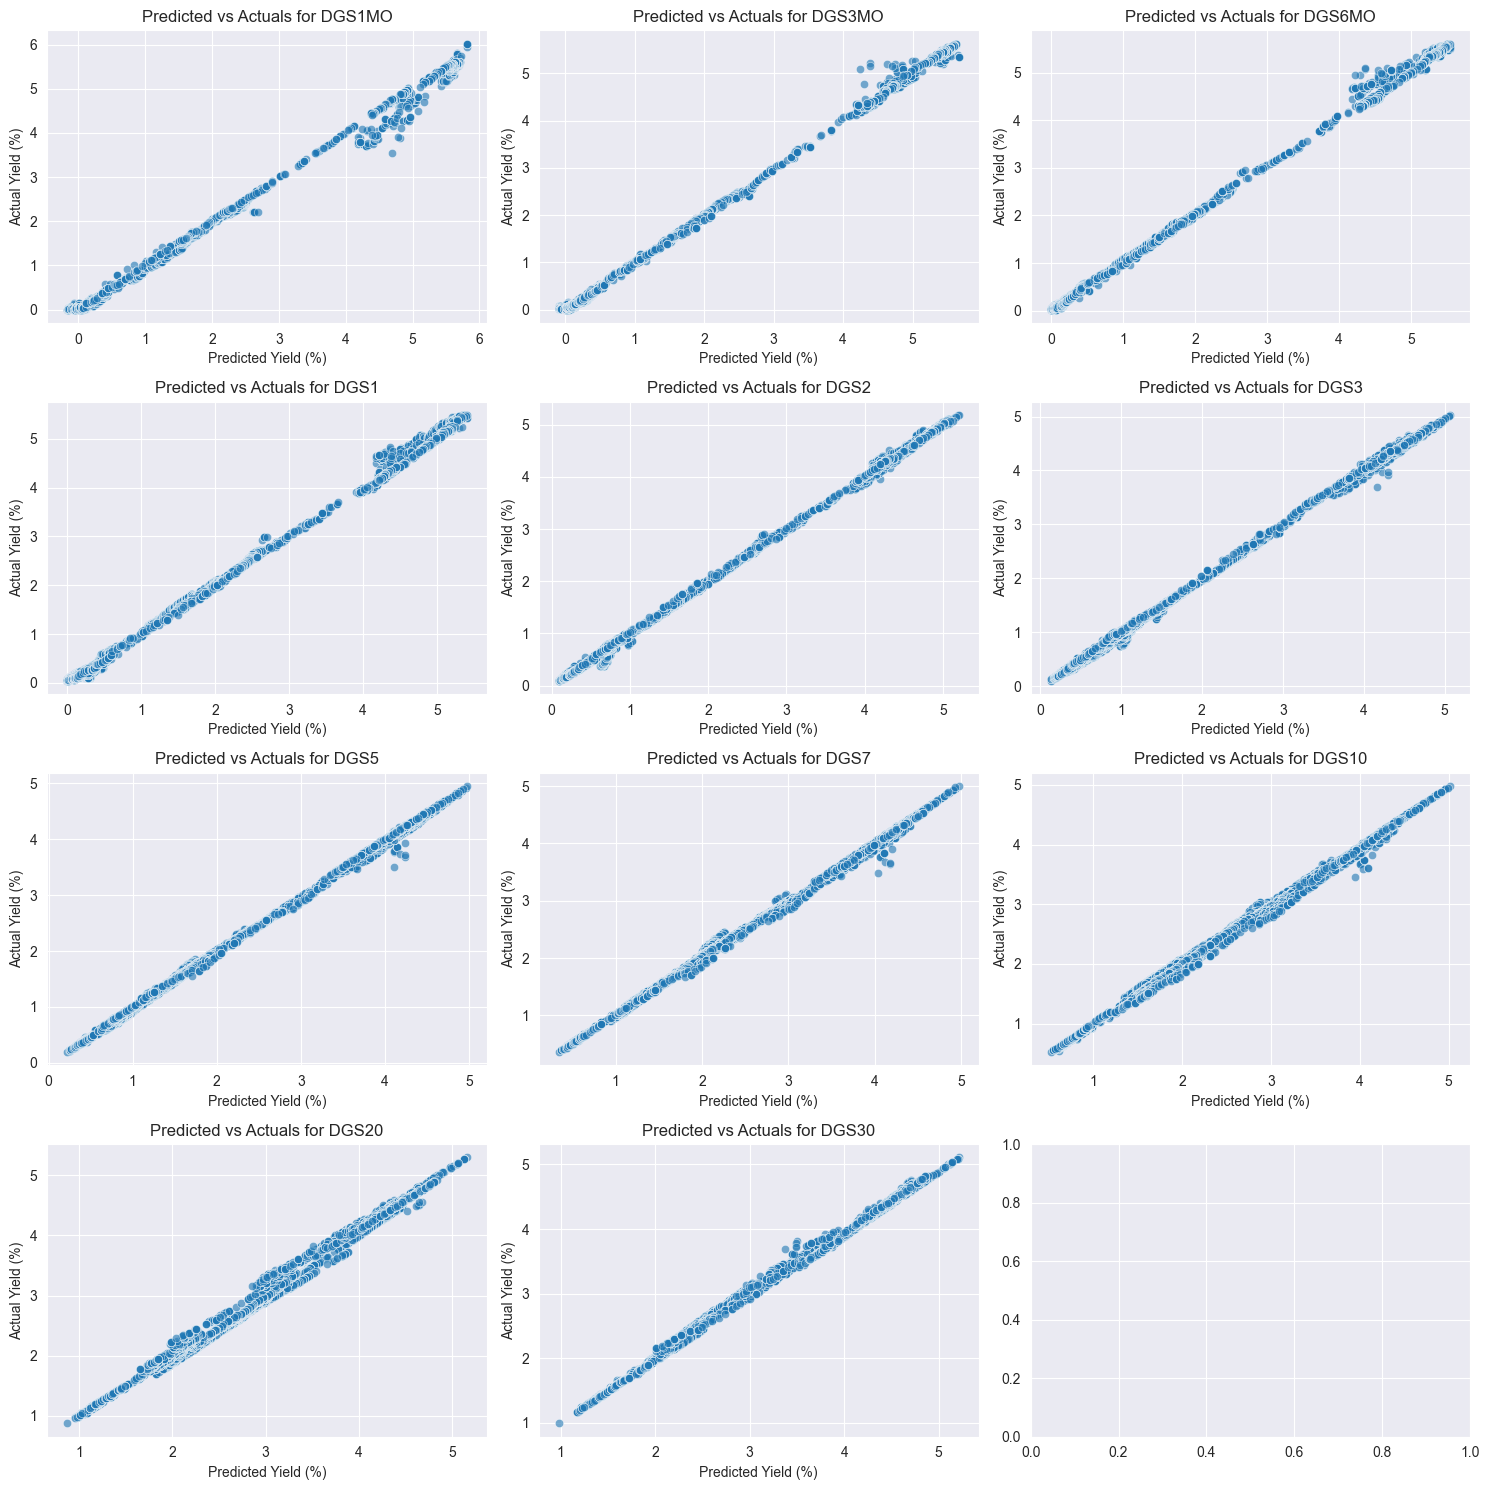

In [21]:
# create a scatter plot for each maturity using a subplot
fig, axes = plt.subplots(4, 3, figsize=(15, 15))
axes = axes.flatten()
for i, maturity in enumerate(dependent_varaibles):
    sns.scatterplot(data=bond_yields_combined_actuals[bond_yields_combined_actuals['Maturity'] == maturity], x='Predicted_Yield', y='Actuals', ax=axes[i], alpha=0.6)
    axes[i].set_title(f'Predicted vs Actuals for {maturity}')
    axes[i].set_xlabel('Predicted Yield (%)')
    axes[i].set_ylabel('Actual Yield (%)')
plt.tight_layout()
plt.show()

## Vector Autoregression (VAR) Model and Analysis

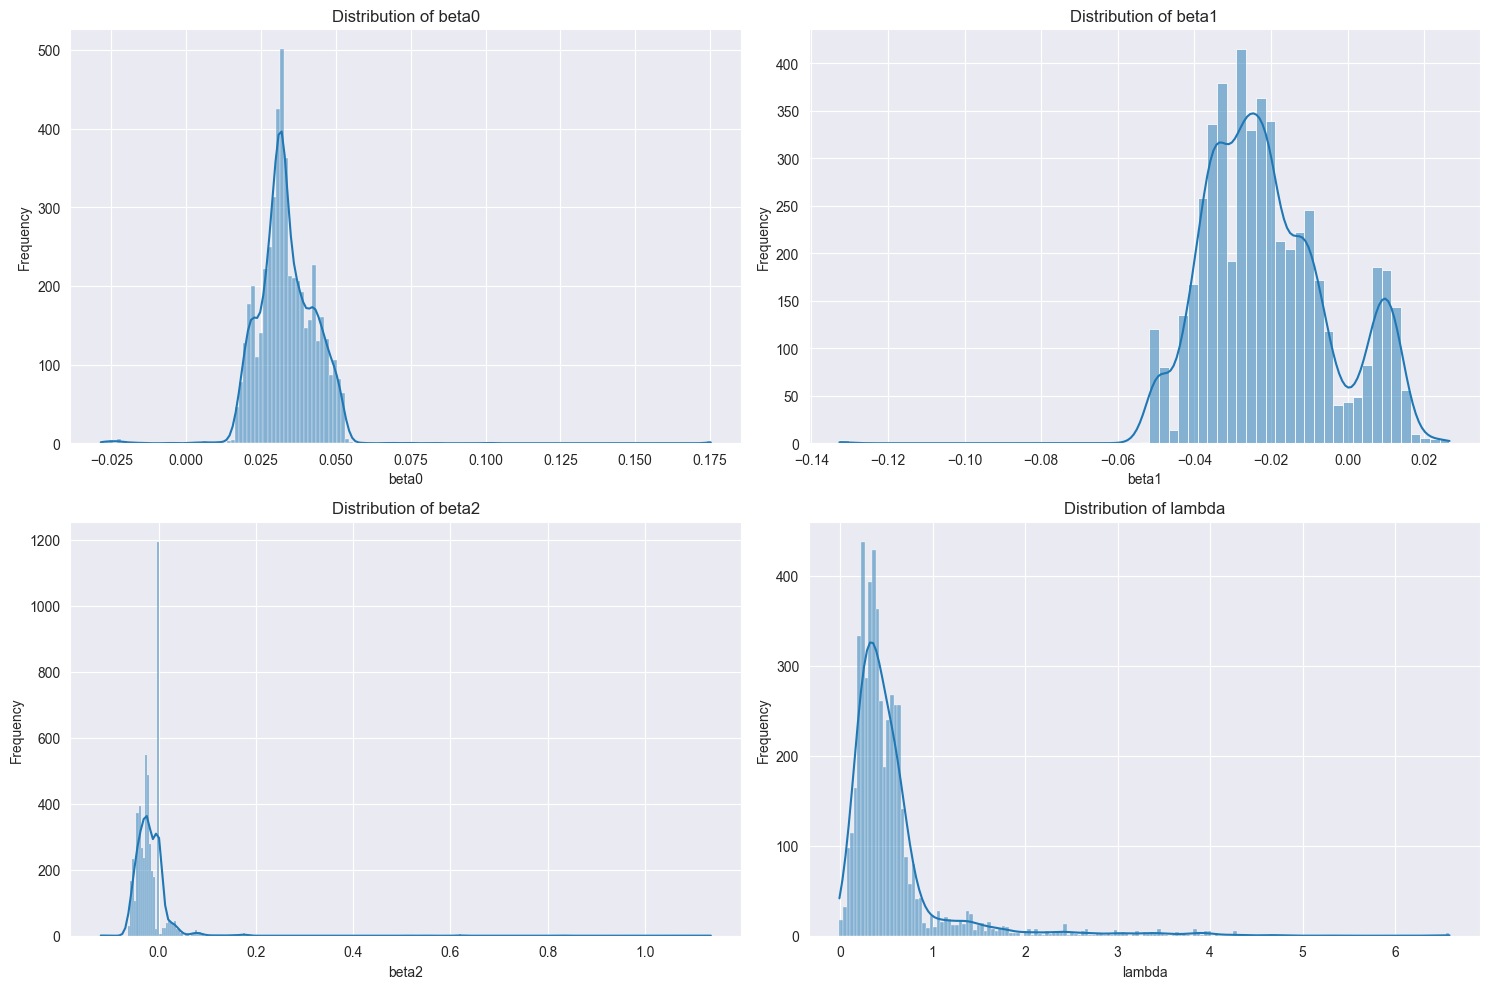

In [22]:
# plot the distributions of the nelson_siegel parameters
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()
for i, param in enumerate(ns_param_columns):
    sns.histplot(bond_yields_ns_params[param], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {param}')
    axes[i].set_xlabel(param)
    axes[i].set_ylabel('Frequency')
plt.tight_layout()

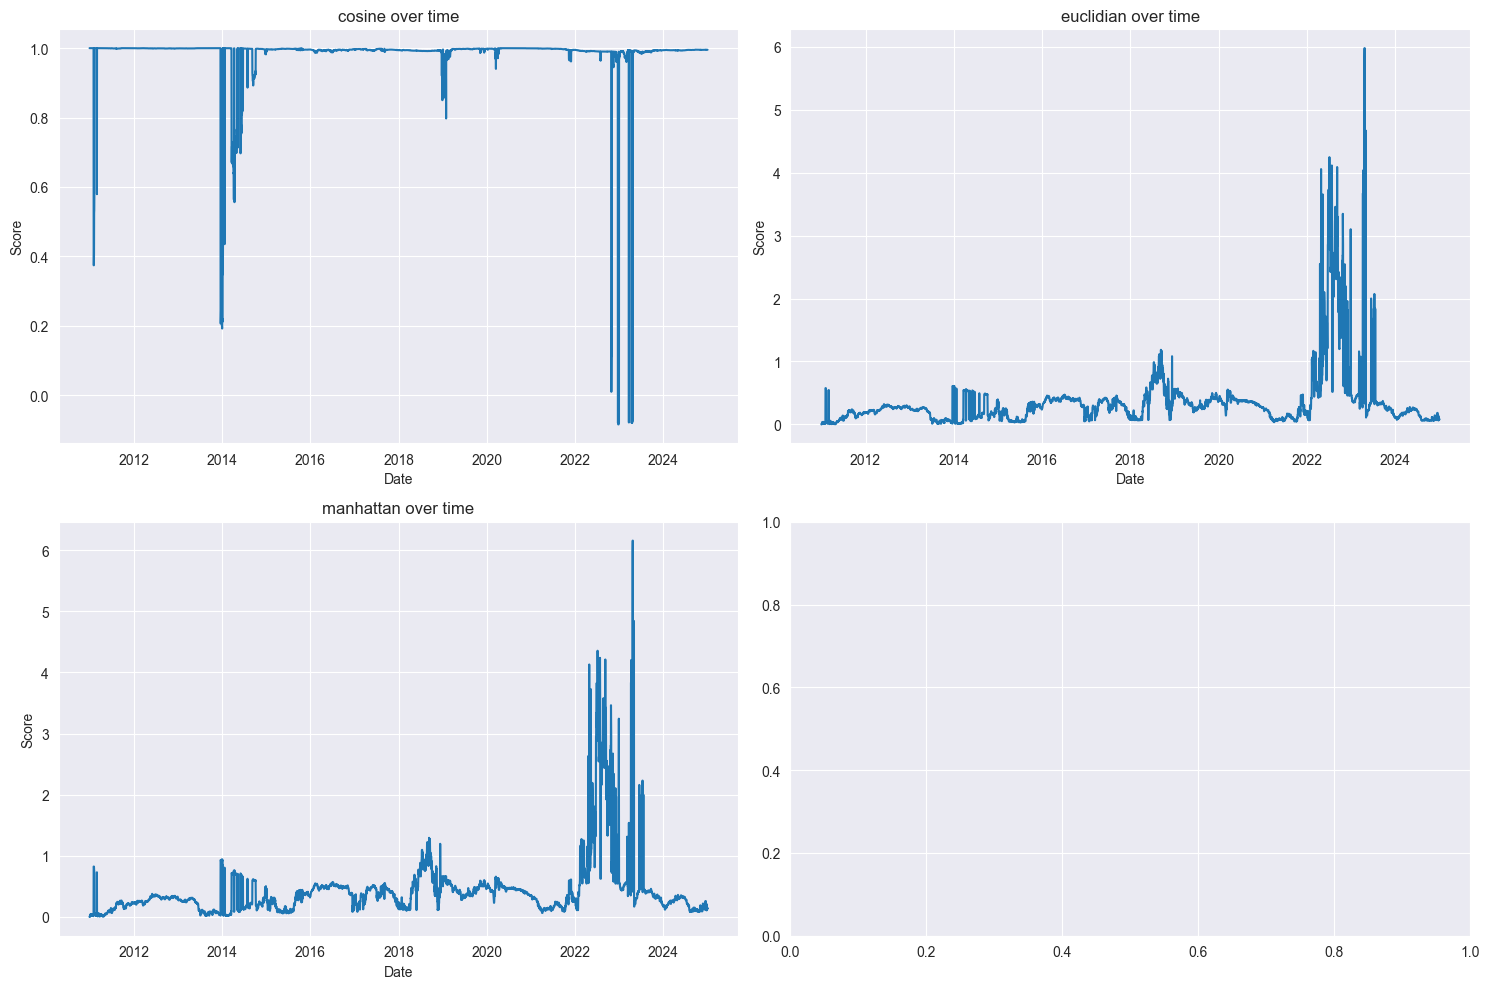

In [24]:
# get the cosine similarity between index 1 and all other indexes in the ns params dataframe
# target_row = bond_yields_ns_params[['beta0', 'beta1', 'beta2', 'lambda']].iloc[0].values.reshape(1, -1)
# similarities = cosine_similarity(target_row, bond_yields_ns_params[['beta0', 'beta1', 'beta2', 'lambda']].values)[0]
# bond_yields_ns_params['cosine'] = similarities
# # get the manahattan distance
# manhattan = manhattan_distances(target_row, bond_yields_ns_params[['beta0', 'beta1', 'beta2', 'lambda']].values)[0]
# euclidian = euclidean_distances(target_row, bond_yields_ns_params[['beta0', 'beta1', 'beta2', 'lambda']].values)[0]
# bond_yields_ns_params['euclidian'] = euclidian
# bond_yields_ns_params['manhattan'] = manhattan
#
# distinace_metrics = ['cosine', 'euclidian', 'manhattan']

# plot the three measures on a 2 by 2 subplot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()
xlabels = [x.to_timestamp() for x in bond_yields_ns_params.index]
for i, metric in enumerate(distinace_metrics):
     sns.lineplot(x=xlabels, y=metric, data=bond_yields_ns_params, ax=axes[i])
     axes[i].set_title(f'{metric} over time')
     axes[i].set_xlabel('Date')
     axes[i].set_ylabel('Score')
plt.tight_layout()
plt.show()

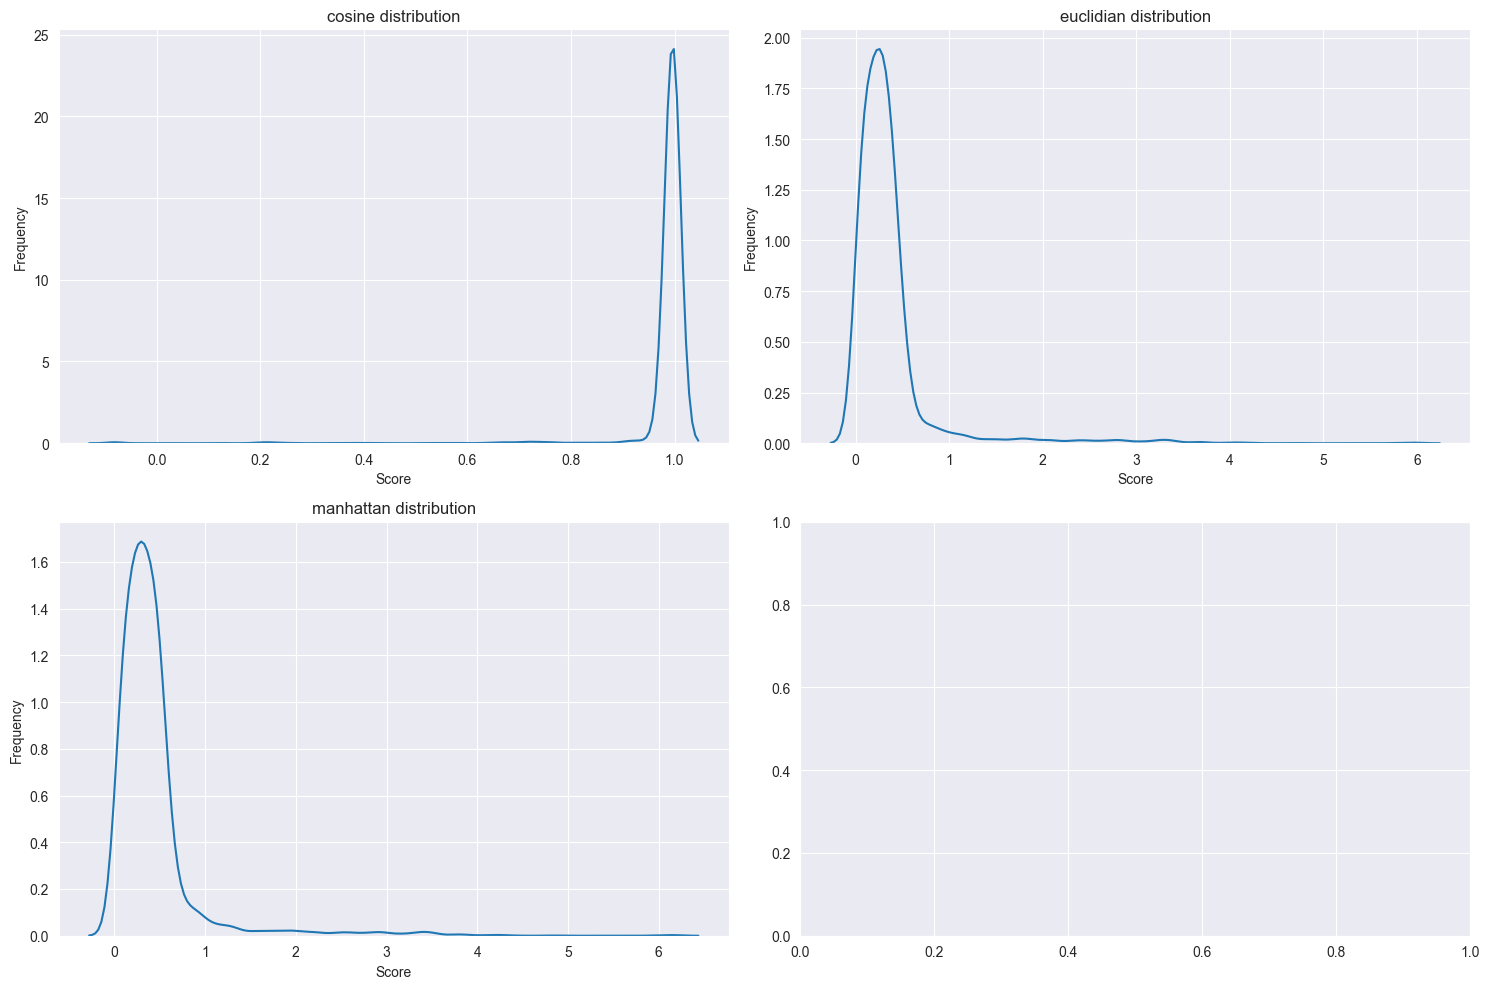

In [25]:
# plot the distributions of the metrics over time
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()
xlabels = [x.to_timestamp() for x in bond_yields_ns_params.index]
for i, metric in enumerate(distinace_metrics):
     sns.kdeplot(x=metric, data=bond_yields_ns_params, ax=axes[i])
     axes[i].set_title(f'{metric} distribution')
     axes[i].set_xlabel('Score')
     axes[i].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

## Nelson Siegel Factors

In [8]:
# load the factor description
factor_description = pd.read_parquet('data/fred_series.parquet')
factor_description.head()

id                                              title  \
489           EXPINF1YR                          1-Year Expected Inflation   
485  REAINTRATREARAT1YE                          1-Year Real Interest Rate   
546              DTB1YR  1-Year Treasury Bill Secondary Market Rate, Di...   
44               T10YIE                   10-Year Breakeven Inflation Rate   
415          EXPINF10YR                         10-Year Expected Inflation   

    observation_start observation_end frequency frequency_short    units  \
489        1982-01-01      2025-07-01   Monthly               M  Percent   
485        1982-01-01      2025-07-01   Monthly               M  Percent   
546        1959-07-15      2025-07-31     Daily               D  Percent   
44         2003-01-02      2025-08-01     Daily               D  Percent   
415        1982-01-01      2025-07-01   Monthly               M  Percent   

    units_short      seasonal_adjustment seasonal_adjustment_short  \
489           %  Not Seasonally Adjusted                       NSA   
485           %  Not Seasonally Adjusted                       NSA   
546           %  Not Seasonally Adjusted                       NSA   
44            %  Not Seasonally Adjusted                       NSA   
415           %  Not Seasonally Adjusted                       NSA   

               last_updated  popularity  group_popularity  \
489  2025-07-15 14:33:09-05          65                65   
485  2025-07-15 14:33:03-05          65                65   
546  2025-08-01 15:18:10-05          59                64   
44   2025-08-01 16:02:18-05          89                89   
415  2025-07-15 14:33:10-05          67                67   

                                                 notes  
489  The Federal Reserve Bank of Cleveland estimate...  
485  The Federal Reserve Bank of Cleveland estimate...  
546  data source (https://www.federalreserve.gov/ap...  
44   The breakeven inflation rate represents a meas...  
415  The Federal Reserve Bank of Cleveland estimate...

In [9]:
factor_description[(factor_description["frequency"].str.contains("Weekly")) & ~(factor_description["id"].isin(dependent_varaibles))][["id", "title", "frequency"]]

id                                              title  \
186     MORTGAGE15US  15-Year Fixed Rate Mortgage Average in the Uni...   
1       MORTGAGE30US  30-Year Fixed Rate Mortgage Average in the Uni...   
486           IC4WSA            4-Week Moving Average of Initial Claims   
714      MORTGAGE5US  5/1-Year Adjustable Rate Mortgage Average in t...   
769             SWPT  Assets: Central Bank Liquidity Swaps: Central ...   
181  H41RESPPALDKNWW  Assets: Liquidity and Credit Facilities: Loans...   
675         WLCFLPCL  Assets: Liquidity and Credit Facilities: Loans...   
369          WSHOMCB  Assets: Securities Held Outright: Mortgage-Bac...   
996          WSHOSHO  Assets: Securities Held Outright: Securities H...   
302           TREAST  Assets: Securities Held Outright: U.S. Treasur...   
14             WALCL  Assets: Total Assets: Total Assets (Less Elimi...   
420        RESPPANWW  Assets: Total Assets: Total Assets: Wednesday ...   
258          TOTBKCR                  Bank Credit, All Commercial Banks   
674            ANFCI  Chicago Fed Adjusted National Financial Condit...   
111             NFCI    Chicago Fed National Financial Conditions Index   
247            TOTCI  Commercial and Industrial Loans, All Commercia...   
751   CLSACBW027SBOG               Consumer Loans, All Commercial Banks   
116   CCLACBW027SBOG  Consumer Loans: Credit Cards and Other Revolvi...   
219             CCSA            Continued Claims (Insured Unemployment)   
952          WCURRNS                           Currency Component of M1   
124   DPSACBW027SBOG                     Deposits, All Commercial Banks   
91              ICSA                                     Initial Claims   
529           WDTGAL  Liabilities and Capital: Liabilities: Deposits...   
113          WTREGEN  Liabilities and Capital: Liabilities: Deposits...   
792           WLODLL  Liabilities and Capital: Liabilities: Deposits...   
458     RESPPLLOPNWW  Liabilities and Capital: Liabilities: Earnings...   
574           WLRRAL  Liabilities and Capital: Liabilities: Reverse ...   
483         WRBWFRBL  Liabilities and Capital: Other Factors Drainin...   
166          WRESBAL  Liabilities and Capital: Other Factors Drainin...   
262            TOTLL  Loans and Leases in Bank Credit, All Commercia...   
50             WM1NS                                                 M1   
989               M1                                  M1 (DISCONTINUED)   
13             WM2NS                                                 M2   
564               M2                                  M2 (DISCONTINUED)   
410   CREACBW027SBOG  Real Estate Loans: Commercial Real Estate Loan...   
400           WRMFNS                          Retail Money Market Funds   
252          STLFSI4               St. Louis Fed Financial Stress Index   
538   TLAACBW027SBOG                 Total Assets, All Commercial Banks   
740     ADPWNUSNERSA           Total Nonfarm Private Payroll Employment   
945   TMBACBW027SBOG  Treasury and Agency Securities: Mortgage-Backe...   
983          GASDESW                              US Diesel Sales Price   
357          GASREGW              US Regular All Formulations Gas Price   
414              WEI        Weekly Economic Index (Lewis-Mertens-Stock)   

                    frequency  
186   Weekly, Ending Thursday  
1     Weekly, Ending Thursday  
486   Weekly, Ending Saturday  
714   Weekly, Ending Thursday  
769   Weekly, As of Wednesday  
181                    Weekly  
675   Weekly, As of Wednesday  
369   Weekly, As of Wednesday  
996   Weekly, As of Wednesday  
302   Weekly, As of Wednesday  
14    Weekly, As of Wednesday  
420   Weekly, As of Wednesday  
258  Weekly, Ending Wednesday  
674     Weekly, Ending Friday  
111     Weekly, Ending Friday  
247  Weekly, Ending Wednesday  
751  Weekly, Ending Wednesday  
116  Weekly, Ending Wednesday  
219   Weekly, Ending Saturday  
952     Weekly, Ending Monday  
124  Weekly, Ending Wednesday  
91    Weekly,

In [10]:
factors = [
    "1-Year Real Interest Rate",
    "10-Year Expected Inflation",
    "10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity",
    "10-Year Treasury Constant Maturity Minus 3-Month Treasury Constant Maturity",
    "10-Year Treasury Constant Maturity Minus Federal Funds Rate",
    "10-Year Breakeven Inflation Rate",
    # "30-Day Average SOFR",
    "30-Year Expected Inflation",
    "2-Year Expected Inflation",
    # "180-Day Average SOFR",
    # "90-Day Average SOFR",
    "CBOE Volatility Index: VIX",
    # "Canadian Dollars to U.S. Dollar Spot Exchange Rate",
    "Effective Federal Funds Rate",
    # "SOFR Index",
    "Federal Surplus or Deficit [-]",
    "Median Consumer Price Index",
    "Smoothed U.S. Recession Probabilities",
    "Sticky Price Consumer Price Index",
    "Total Unemployed, Plus All Persons Marginally Attached to the Labor Force, Plus Total Employed Part Time for Economic Reasons, as a Percent of the Civilian Labor Force Plus All Persons Marginally Attached to the Labor Force (U-6)",
    # "DGS10",
    # "DGS20",
    # "DGS2",
]

factor_ids = factor_description[factor_description["title"].isin(factors)]["id"].tolist()
# make sure the list matches with what was retrieved
assert len(factor_ids) == len(factors)
factor_description[factor_description["title"].isin(factors)][["id", "title"]]

id                                              title
485   REAINTRATREARAT1YE                          1-Year Real Interest Rate
44                T10YIE                   10-Year Breakeven Inflation Rate
415           EXPINF10YR                         10-Year Expected Inflation
0                 T10Y2Y  10-Year Treasury Constant Maturity Minus 2-Yea...
15                T10Y3M  10-Year Treasury Constant Maturity Minus 3-Mon...
254               T10YFF  10-Year Treasury Constant Maturity Minus Feder...
837            EXPINF2YR                          2-Year Expected Inflation
778           EXPINF30YR                         30-Year Expected Inflation
215               VIXCLS                         CBOE Volatility Index: VIX
165                 EFFR                       Effective Federal Funds Rate
104          MTSDS133FMS                     Federal Surplus or Deficit [-]
322    MEDCPIM157SFRBCLE                        Median Consumer Price Index
255        RECPROUSM156N              Smoothed U.S. Recession Probabilities
745  STICKCPIM158SFRBATL                  Sticky Price Consumer Price Index
423               U6RATE  Total Unemployed, Plus All Persons Marginally ...

In [27]:
# load the factor data
factor_data = pd.read_parquet('data/fred_prorcessed_daily.parquet')[factor_ids]
factor_data = factor_data.loc[pd.Timestamp('2011-01-01').to_period('D'):]
# get the null count
factor_data.isnull().sum() / factor_data.shape[0]

REAINTRATREARAT1YE     0.0
T10YIE                 0.0
EXPINF10YR             0.0
T10Y2Y                 0.0
T10Y3M                 0.0
T10YFF                 0.0
EXPINF2YR              0.0
EXPINF30YR             0.0
VIXCLS                 0.0
EFFR                   0.0
MTSDS133FMS            0.0
MEDCPIM157SFRBCLE      0.0
RECPROUSM156N          0.0
STICKCPIM158SFRBATL    0.0
U6RATE                 0.0
dtype: float64

In [28]:
# scale the data to single digits if not done already
def scale_to_single_digits(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    """
    Scale each column down so the max value is single digits
    """
    # iterate through each column
    for col in cols:
        max_val = df[col].max()
        if pd.isna(max_val) or max_val == 0:
            continue
        scale_factor = 10 ** (len(str(int(max_val))) - 1)
        df.loc[:, col] = ((df[col] / scale_factor) / 10).round(5)
        # df[col].describe()
    return df

factor_data = scale_to_single_digits(df=factor_data, cols=factor_data.columns)
factor_data.describe()

REAINTRATREARAT1YE       T10YIE   EXPINF10YR       T10Y2Y       T10Y3M  \
count         5114.000000  5114.000000  5114.000000  5114.000000  5114.000000   
mean            -0.036937     0.205395     0.182853     0.091232     0.112315   
std              0.187413     0.035357     0.028868     0.091561     0.124087   
min             -0.396640     0.050000     0.115830    -0.108000    -0.189000   
25%             -0.153350     0.180000     0.163000     0.021000     0.032000   
50%             -0.087315     0.212000     0.180780     0.093000     0.141000   
75%              0.063285     0.231000     0.204830     0.155000     0.198000   
max              0.800560     0.302000     0.245470     0.291000     0.360000   

            T10YFF    EXPINF2YR   EXPINF30YR       VIXCLS         EFFR  \
count  5114.000000  5114.000000  5114.000000  5114.000000  5114.000000   
mean      0.114356     0.178591     0.215733     0.179875     0.130524   
std       0.118187     0.047275     0.016765     0.069022     0.175117   
min      -0.171000     0.042400     0.178340     0.091400     0.004000   
25%       0.051000     0.148020     0.203400     0.133725     0.009000   
50%       0.138000     0.169510     0.215880     0.161400     0.030000   
75%       0.194000     0.204850     0.228323     0.206000     0.192000   
max       0.359000     0.318170     0.251220     0.826900     0.533000   

       MTSDS133FMS  MEDCPIM157SFRBCLE  RECPROUSM156N  STICKCPIM158SFRBATL  \
count  5114.000000        5114.000000    5114.000000          5114.000000   
mean     -0.107625           0.025451       0.001412             0.292710   
std       0.154870           0.012037       0.010837             0.158233   
min      -0.864070           0.009490       0.000000            -0.175550   
25%      -0.192610           0.017640       0.000040             0.202160   
50%      -0.106530           0.021460       0.000120             0.254820   
75%      -0.023190           0.028063       0.000260             0.341390   
max       0.308220           0.065830       0.100000             0.842170   

            U6RATE  
count  5114.000000  
mean      0.103036  
std       0.033447  
min       0.066000  
25%       0.074000  
50%       0.095500  
75%       0.127750  
max       0.229000

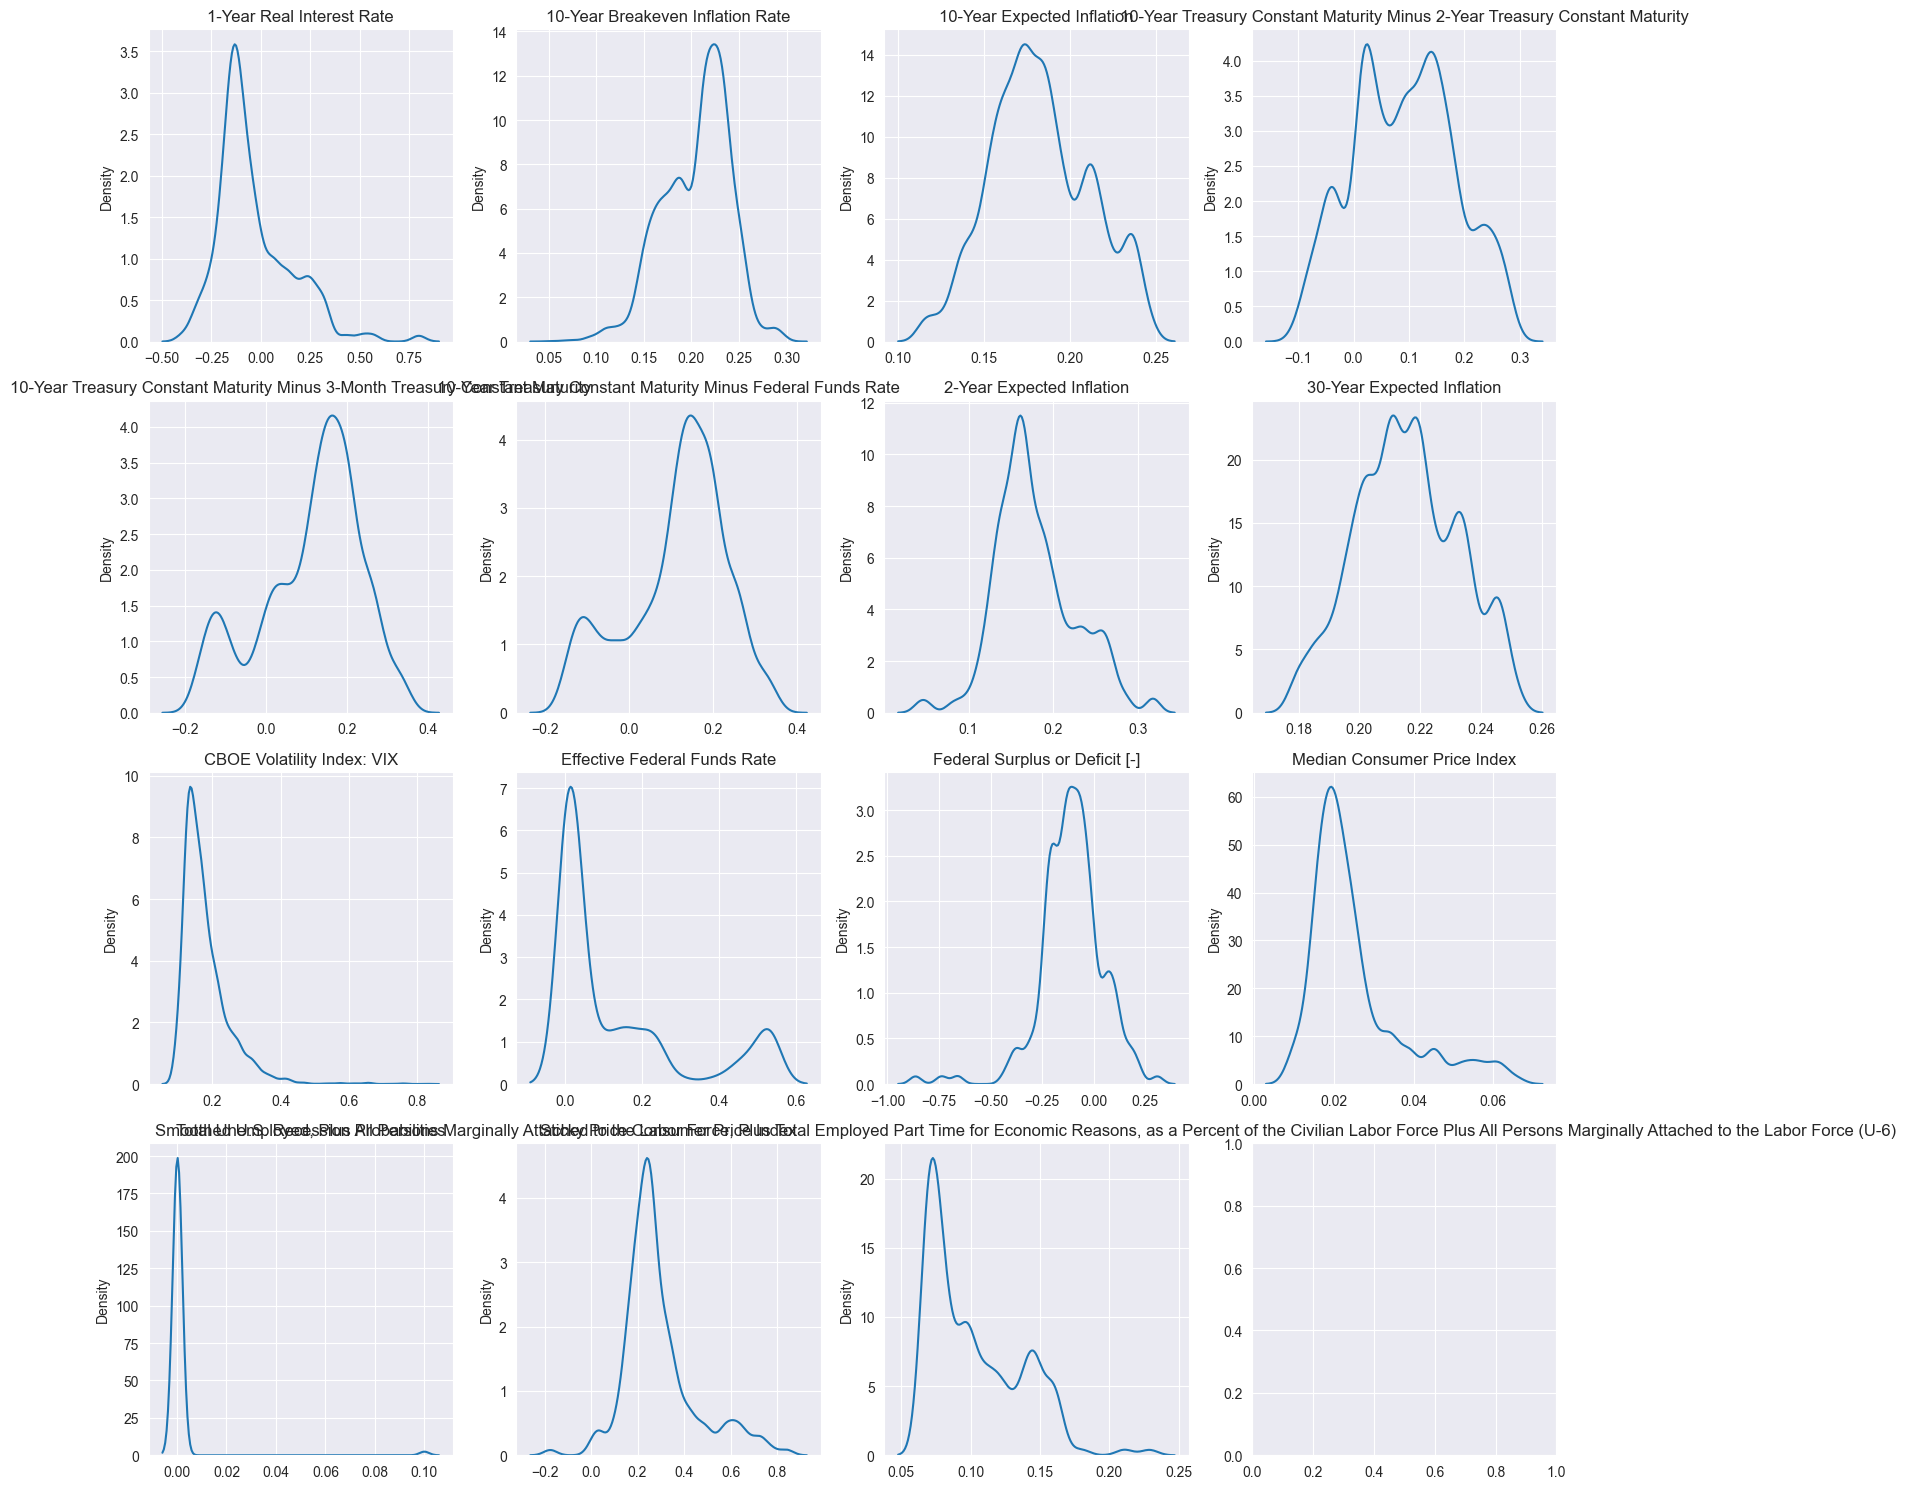

In [72]:
# plot a kde distribbution for the 16 factors on a 8 by 8 subplot graph
graph_values = factor_description[factor_description["title"].isin(factors)][["id", "title"]].values
fig, axes = plt.subplots(4, 4, figsize=(15, 15))
axes = axes.flatten()
for i, factor in enumerate(graph_values):
    id = factor[0]
    title = factor[1]
    sns.kdeplot(factor_data[id], ax=axes[i])
    axes[i].set_title(f'{title}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Density')
plt.tight_layout()
plt.show()

In [29]:
# merge the factor data with the nelson siegel params data
print(f"Shape prior: {bond_yields_ns_params.shape}")
bond_yields_ns_params = bond_yields_ns_params.merge(factor_data, left_index=True, right_index=True, how='left')
print(f"Shape of new data: {bond_yields_ns_params.shape}")
print(f"Null Count \n {bond_yields_ns_params.isnull().sum()}")

Shape prior: (5114, 8)
Shape of new data: (5114, 23)
Null Count 
 beta0                  0
beta1                  0
beta2                  0
lambda                 0
beta0_running_mean     0
beta1_running_mean     0
beta2_running_mean     0
lambda_running_mean    0
REAINTRATREARAT1YE     0
T10YIE                 0
EXPINF10YR             0
T10Y2Y                 0
T10Y3M                 0
T10YFF                 0
EXPINF2YR              0
EXPINF30YR             0
VIXCLS                 0
EFFR                   0
MTSDS133FMS            0
MEDCPIM157SFRBCLE      0
RECPROUSM156N          0
STICKCPIM158SFRBATL    0
U6RATE                 0
dtype: int64


In [30]:
# create a copy of 4 different dataframes where the dependent variables, the coefficient are shifted backwards 1, 7, 30, and 60 days
bond_yields_ns_params_shifted_1 = bond_yields_ns_params.copy()
bond_yields_ns_params_shifted_7 = bond_yields_ns_params.copy()
bond_yields_ns_params_shifted_30 = bond_yields_ns_params.copy()
bond_yields_ns_params_shifted_60 = bond_yields_ns_params.copy()

dependent_varaibles = ['beta0', 'beta1', 'beta2', 'lambda']
for dependent_varaible in dependent_varaibles:
    bond_yields_ns_params_shifted_1[f"{dependent_varaible}_future_val"] = bond_yields_ns_params_shifted_1[dependent_varaible].shift(-1)
    bond_yields_ns_params_shifted_7[f"{dependent_varaible}_future_val"] = bond_yields_ns_params_shifted_7[dependent_varaible].shift(-7)
    bond_yields_ns_params_shifted_30[f"{dependent_varaible}_future_val"] = bond_yields_ns_params_shifted_30[dependent_varaible].shift(-30)
    bond_yields_ns_params_shifted_60[f"{dependent_varaible}_future_val"] = bond_yields_ns_params_shifted_60[dependent_varaible].shift(-60)


print(f"Null values 1 day: {bond_yields_ns_params_shifted_1.isna().sum()}")
print(f"Null values 7 day: {bond_yields_ns_params_shifted_7.isna().sum()}")
print(f"Null values 30 day: {bond_yields_ns_params_shifted_30.isna().sum()}")
print(f"Null values 60 day: {bond_yields_ns_params_shifted_60.isna().sum()}")

bond_yields_ns_params_shifted_60.tail()

Null values 1 day: beta0                  0
beta1                  0
beta2                  0
lambda                 0
beta0_running_mean     0
beta1_running_mean     0
beta2_running_mean     0
lambda_running_mean    0
REAINTRATREARAT1YE     0
T10YIE                 0
EXPINF10YR             0
T10Y2Y                 0
T10Y3M                 0
T10YFF                 0
EXPINF2YR              0
EXPINF30YR             0
VIXCLS                 0
EFFR                   0
MTSDS133FMS            0
MEDCPIM157SFRBCLE      0
RECPROUSM156N          0
STICKCPIM158SFRBATL    0
U6RATE                 0
beta0_future_val       1
beta1_future_val       1
beta2_future_val       1
lambda_future_val      1
dtype: int64
Null values 7 day: beta0                  0
beta1                  0
beta2                  0
lambda                 0
beta0_running_mean     0
beta1_running_mean     0
beta2_running_mean     0
lambda_running_mean    0
REAINTRATREARAT1YE     0
T10YIE                 0
EXPINF10YR             0

beta0     beta1     beta2    lambda  beta0_running_mean  \
period                                                                   
2024-12-27  0.049455 -0.005411 -0.013402  0.677796            0.033424   
2024-12-28  0.049455 -0.005411 -0.013402  0.677796            0.033428   
2024-12-29  0.049455 -0.005411 -0.013402  0.677796            0.033431   
2024-12-30  0.049077 -0.004801 -0.015363  0.657724            0.033434   
2024-12-31  0.049275 -0.005146 -0.015512  0.668691            0.033437   

            beta1_running_mean  beta2_running_mean  lambda_running_mean  \
period                                                                    
2024-12-27           -0.020561           -0.016674             0.567887   
2024-12-28           -0.020558           -0.016674             0.567909   
2024-12-29           -0.020555           -0.016673             0.567930   
2024-12-30           -0.020552           -0.016673             0.567948   
2024-12-31           -0.020549           -0.016673             0.567967   

            REAINTRATREARAT1YE  T10YIE  ...   EFFR  MTSDS133FMS  \
period                                  ...                       
2024-12-27             0.15945   0.234  ...  0.433     -0.08673   
2024-12-28             0.15945   0.234  ...  0.433     -0.08673   
2024-12-29             0.15945   0.234  ...  0.433     -0.08673   
2024-12-30             0.15945   0.231  ...  0.433     -0.08673   
2024-12-31             0.15945   0.234  ...  0.433     -0.08673   

            MEDCPIM157SFRBCLE  RECPROUSM156N  STICKCPIM158SFRBATL  U6RATE  \
period                                                                      
2024-12-27            0.02656        0.00008              0.26038   0.075   
2024-12-28            0.02656        0.00008              0.26038   0.075   
2024-12-29            0.02656        0.00008              0.26038   0.075   
2024-12-30            0.02656        0.00008              0.26038   0.075   
2024-12-31            0.02656        0.00008              0.26038   0.075   

            beta0_future_val  beta1_future_val  beta2_future_val  \
period                                                             
2024-12-27               NaN               NaN               NaN   
2024-12-28               NaN               NaN               NaN   
2024-12-29               NaN               NaN               NaN   
2024-12-30               NaN               NaN               NaN   
2024-12-31               NaN               NaN               NaN   

            lambda_future_val  
period                         
2024-12-27                NaN  
2024-12-28                NaN  
2024-12-29                NaN  
2024-12-30                NaN  
2024-12-31                NaN  

[5 rows x 27 columns]

In [31]:
# for each factor create lags 1, 7, 30, and 60
data_sets = [
    bond_yields_ns_params_shifted_1,
    bond_yields_ns_params_shifted_7,
    bond_yields_ns_params_shifted_30,
    bond_yields_ns_params_shifted_60
]
new_data = []
factor_ids = factor_ids + ["DGS2", "DGS10", "DGS20", '2yr_10yr_spread', '2yr_10yr_spread']
for data in tqdm(data_sets, desc="Creating feature engineered feature for Each dataset"):
    # merge the DGS values to the data
    data = data.merge(bond_yields_train[["DGS2", "DGS10", "DGS20"]], left_index=True, right_index=True, how='left')
    data['2yr_10yr_spread'] = data['DGS10'] - data['DGS2']
    data['2yr_10yr_spread'] = data['DGS20'] - data['DGS2']
    # scale the calculated columns
    data = scale_to_single_digits(df=data, cols=["DGS2", "DGS10", "DGS20", '2yr_10yr_spread', '2yr_10yr_spread'])
    for factor in factor_ids:
        # create transition columns for each factor
        data[f'{factor}_transition_1'] = data[factor] - data[factor].shift(1)
        data[f'{factor}_transition_7'] = data[factor] - data[factor].shift(7)
        data[f'{factor}_transition_30'] = data[factor] - data[factor].shift(30)
        data[f'{factor}_transition_60'] = data[factor] - data[factor].shift(60)
        # create moving averages
        data[f'{factor}_moving_avg_30'] = data[factor].rolling(window=30).mean()
        data[f'{factor}_moving_avg_60'] = data[factor].rolling(window=60).mean()
        # create exponential moving averages
        data[f'{factor}_exp_moving_avg_30'] = data[factor].ewm(span=30, adjust=False).mean()
        data[f'{factor}_exp_moving_avg_60'] = data[factor].ewm(span=60, adjust=False).mean()
    new_data.append(data)

bond_yields_ns_params_shifted_1 = new_data[0]
bond_yields_ns_params_shifted_7 = new_data[1]
bond_yields_ns_params_shifted_30 = new_data[2]
bond_yields_ns_params_shifted_60 = new_data[3]
print(f"Shape of 1 day shift data: {bond_yields_ns_params_shifted_1.shape}")
print(f"Shape of 7 day shift data: {bond_yields_ns_params_shifted_7.shape}")
print(f"Shape of 30 day shift data: {bond_yields_ns_params_shifted_30.shape}")
print(f"Shape of 60 day shift data: {bond_yields_ns_params_shifted_60.shape}")

Creating feature engineered feature for Each dataset:   0%|          | 0/4 [00:00<?, ?it/s]/var/folders/j5/d8d1mkwd55q6sz79ygcfg1rr0000gn/T/ipykernel_77592/3702165604.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{factor}_transition_7'] = data[factor] - data[factor].shift(7)
/var/folders/j5/d8d1mkwd55q6sz79ygcfg1rr0000gn/T/ipykernel_77592/3702165604.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{factor}_transition_30'] = data[factor] - data[factor].shift(30)
/var/folders/j5/d8d1mkwd55q6sz79ygcfg1rr000

Shape of 1 day shift data: (5114, 183)
Shape of 7 day shift data: (5114, 183)
Shape of 30 day shift data: (5114, 183)
Shape of 60 day shift data: (5114, 183)


In [ ]:
# persist the data
bond_yields_ns_params_shifted_1.to_parquet('bond_yields_ns_params_shifted_1.parquet')
bond_yields_ns_params_shifted_7.to_parquet('bond_yields_ns_params_shifted_7.parquet')
bond_yields_ns_params_shifted_30.to_parquet('bond_yields_ns_params_shifted_30.parquet')
bond_yields_ns_params_shifted_60.to_parquet('bond_yields_ns_params_shifted_60.parquet')
print('Data saved')

## Correlation analysis

In [33]:
# load the data
bond_yields_ns_params_shifted_1 = pd.read_parquet('data/bond_yields_ns_params_shifted_1.parquet')
bond_yields_ns_params_shifted_7 = pd.read_parquet('data/bond_yields_ns_params_shifted_7.parquet')
bond_yields_ns_params_shifted_30 = pd.read_parquet('data/bond_yields_ns_params_shifted_30.parquet')
bond_yields_ns_params_shifted_60 = pd.read_parquet('data/bond_yields_ns_params_shifted_60.parquet')
# find the correlation between the factors and the dependent variables
# get the correlations between the independent variables and each dependent variable
dependent_varaibles = [x for x in bond_yields_ns_params_shifted_30.columns if "_future_val" in x]
data_sets = [bond_yields_ns_params_shifted_1, bond_yields_ns_params_shifted_7, bond_yields_ns_params_shifted_30, bond_yields_ns_params_shifted_60]
df_correlations = []
for data in tqdm(data_sets, desc="Finding Correlation between Dependent and Independent Variables"):
    rows = []
    counter = 0
    for dependent_var in tqdm(dependent_varaibles):
        independent_cols = [x for x in data.columns if x not in dependent_varaibles]
        # print(f"Dependent variable: {dependent_var}: {independent_cols}")
        for independent_var in independent_cols:
            # get the correlation value between the two variables
            try:
                corr_val = data[[dependent_var, independent_var]].dropna().corr()
                corr_val = corr_val.loc[dependent_var, independent_var]
                # print(f"Correlation between {dependent_var} and {independent_var}: {corr_val}")
                rows.append({
                    'dependent_variable': dependent_var,
                    'independent_variable': independent_var,
                    'correlation': corr_val
                })
            except Exception as e:
                continue

    df_correlation = pd.DataFrame(rows)
    df_correlations.append(df_correlation)

df_correlation1 = df_correlations[0]
df_correlation7 = df_correlations[1]
df_correlation30 = df_correlations[2]
df_correlation60 = df_correlations[3]
# # get the groupby count by dependent_variable
df_correlation_count = df_correlation1['dependent_variable'].value_counts().reset_index()
df_correlation_count.columns = ['dependent_variable', 'count']
df_correlation_count = df_correlation_count.sort_values(by='count', ascending=False)
df_correlation_count.head(15)

Finding Correlation between Dependent and Independent Variables:   0%|          | 0/4 [00:00<?, ?it/s]
100%|██████████| 4/4 [00:00<00:00, 13.70it/s]
Finding Correlation between Dependent and Independent Variables:  25%|██▌       | 1/4 [00:00<00:00,  3.40it/s]
100%|██████████| 4/4 [00:00<00:00, 14.43it/s]
Finding Correlation between Dependent and Independent Variables:  50%|█████     | 2/4 [00:00<00:00,  3.51it/s]
100%|██████████| 4/4 [00:00<00:00, 14.31it/s]
Finding Correlation between Dependent and Independent Variables:  75%|███████▌  | 3/4 [00:00<00:00,  3.53it/s]
100%|██████████| 4/4 [00:00<00:00, 14.19it/s]
Finding Correlation between Dependent and Independent Variables: 100%|██████████| 4/4 [00:01<00:00,  3.51it/s]


dependent_variable  count
0   beta0_future_val    178
1   beta1_future_val    178
2   beta2_future_val    178
3  lambda_future_val    178

In [ ]:
# plot the correlations
# Sort the correlation dataframe by correlation value in descending order
df_correlation_sorted = df_correlation1.sort_values(by='correlation', ascending=False)
df_correlation_sorted['color_mapping'] = df_correlation_sorted['correlation'].apply(lambda x: 'postitive' if x > 0 else 'negative')
# Plot the correlation values using seaborn barplot. Remove x labels. Use green for correlations above 0 and red for those less than. Do this for each dependent variable by creating a 6 by 6 subplot

fig, axes = plt.subplots(2, 2, figsize=(12, 7))
axes = axes.flatten()
for i, dependent_var in enumerate(dependent_varaibles):
    df_tmp = df_correlation_sorted[df_correlation_sorted['dependent_variable'] == dependent_var]
    sns.barplot(data=df_tmp, x='independent_variable', y='correlation', hue='color_mapping', ax=axes[i])
    axes[i].set_title(f'Correlation with {dependent_var}')
    # remove xticks
    axes[i].set_xticklabels([])
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
plt.suptitle('Correlation between Dependent and Independent Variables for 1 day future Params')
plt.tight_layout()

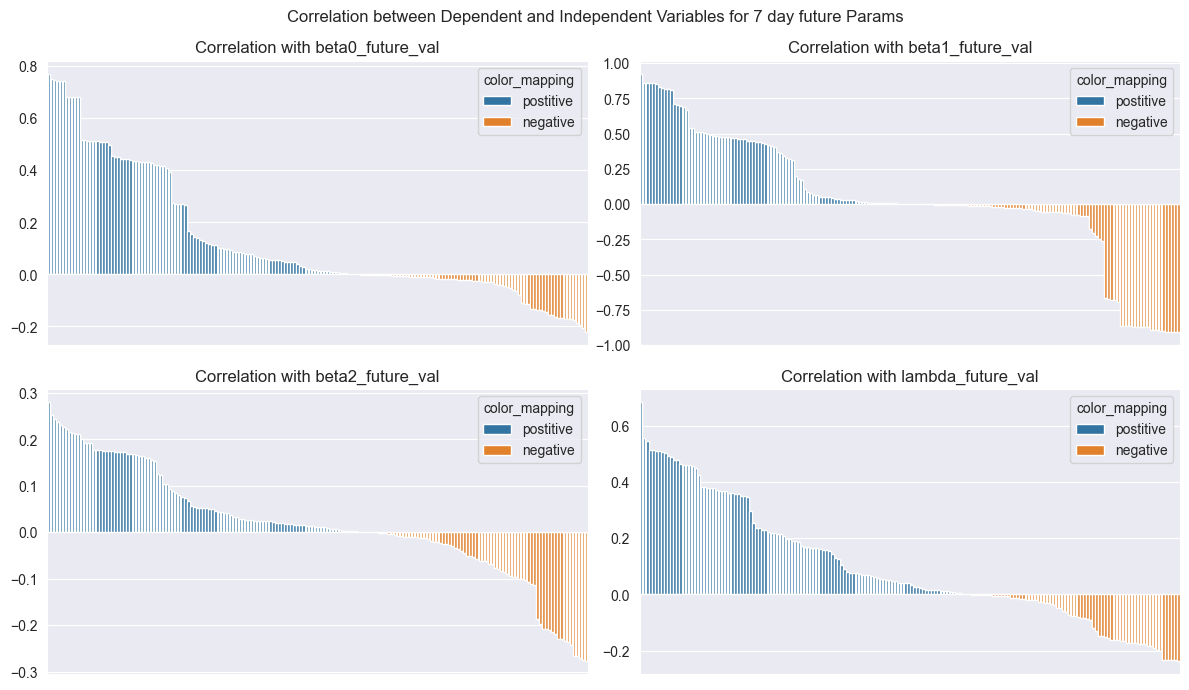

In [106]:
df_correlation_sorted = df_correlation7.sort_values(by='correlation', ascending=False)
df_correlation_sorted['color_mapping'] = df_correlation_sorted['correlation'].apply(lambda x: 'postitive' if x > 0 else 'negative')
# Plot the correlation values using seaborn barplot. Remove x labels. Use green for correlations above 0 and red for those less than. Do this for each dependent variable by creating a 6 by 6 subplot

fig, axes = plt.subplots(2, 2, figsize=(12, 7))
axes = axes.flatten()
for i, dependent_var in enumerate(dependent_varaibles):
    df_tmp = df_correlation_sorted[df_correlation_sorted['dependent_variable'] == dependent_var]
    sns.barplot(data=df_tmp, x='independent_variable', y='correlation', hue='color_mapping', ax=axes[i])
    axes[i].set_title(f'Correlation with {dependent_var}')
    # remove xticks
    axes[i].set_xticklabels([])
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
plt.suptitle('Correlation between Dependent and Independent Variables for 7 day future Params')
plt.tight_layout()

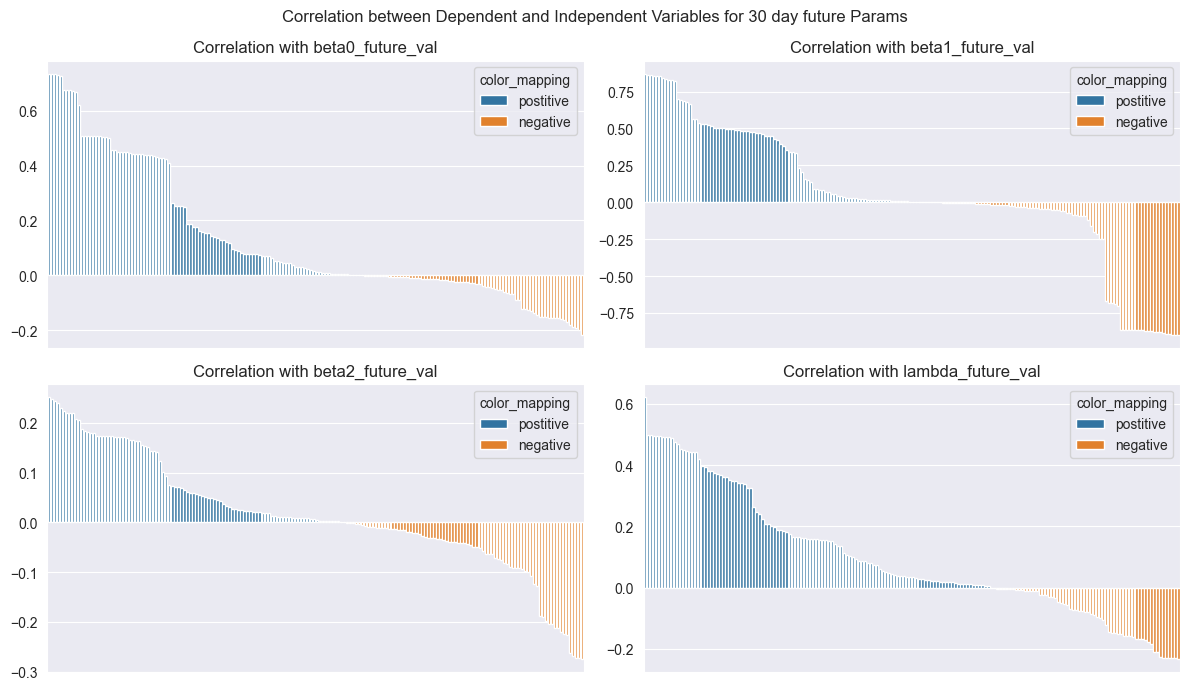

In [107]:
df_correlation_sorted = df_correlation30.sort_values(by='correlation', ascending=False)
df_correlation_sorted['color_mapping'] = df_correlation_sorted['correlation'].apply(lambda x: 'postitive' if x > 0 else 'negative')
# Plot the correlation values using seaborn barplot. Remove x labels. Use green for correlations above 0 and red for those less than. Do this for each dependent variable by creating a 6 by 6 subplot

fig, axes = plt.subplots(2, 2, figsize=(12, 7))
axes = axes.flatten()
for i, dependent_var in enumerate(dependent_varaibles):
    df_tmp = df_correlation_sorted[df_correlation_sorted['dependent_variable'] == dependent_var]
    sns.barplot(data=df_tmp, x='independent_variable', y='correlation', hue='color_mapping', ax=axes[i])
    axes[i].set_title(f'Correlation with {dependent_var}')
    # remove xticks
    axes[i].set_xticklabels([])
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
plt.suptitle('Correlation between Dependent and Independent Variables for 30 day future Params')
plt.tight_layout()

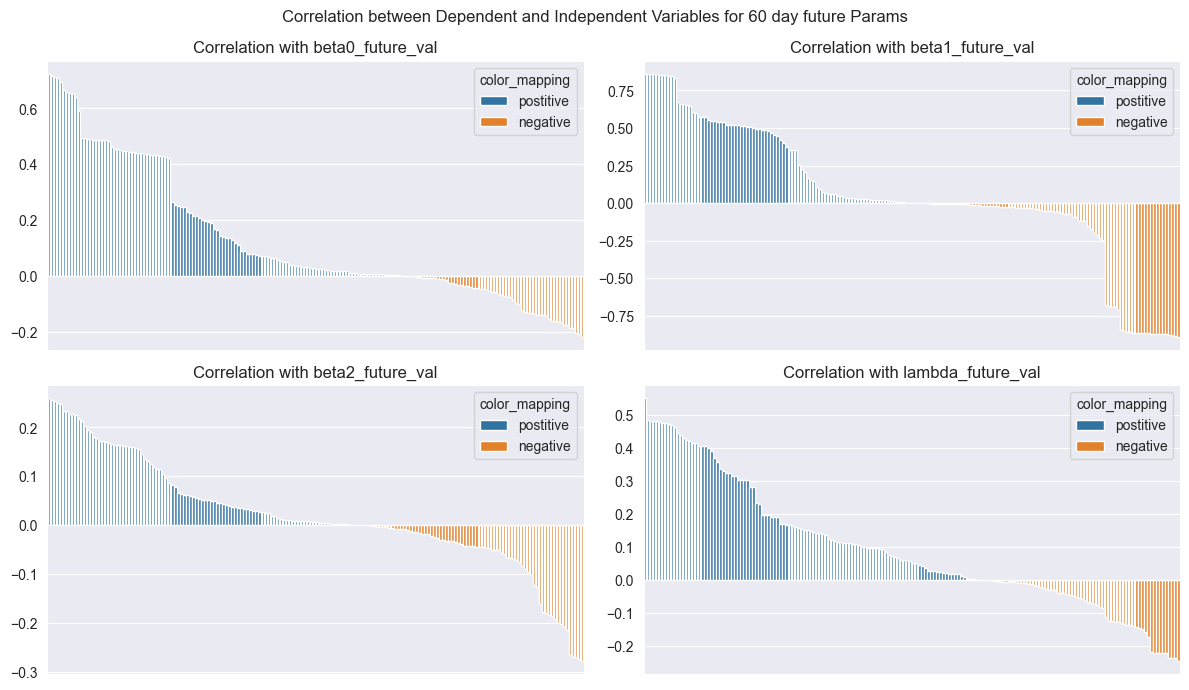

In [108]:
df_correlation_sorted = df_correlation60.sort_values(by='correlation', ascending=False)
df_correlation_sorted['color_mapping'] = df_correlation_sorted['correlation'].apply(lambda x: 'postitive' if x > 0 else 'negative')
# Plot the correlation values using seaborn barplot. Remove x labels. Use green for correlations above 0 and red for those less than. Do this for each dependent variable by creating a 6 by 6 subplot

fig, axes = plt.subplots(2, 2, figsize=(12, 7))
axes = axes.flatten()
for i, dependent_var in enumerate(dependent_varaibles):
    df_tmp = df_correlation_sorted[df_correlation_sorted['dependent_variable'] == dependent_var]
    sns.barplot(data=df_tmp, x='independent_variable', y='correlation', hue='color_mapping', ax=axes[i])
    axes[i].set_title(f'Correlation with {dependent_var}')
    # remove xticks
    axes[i].set_xticklabels([])
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
plt.suptitle('Correlation between Dependent and Independent Variables for 60 day future Params')
plt.tight_layout()

In [34]:
# get the variables with a correlation above or below 0.5 or -0.5 for each dataset
one_day_ahead_correlated_features = df_correlation1[(df_correlation1['correlation'] >= 0.5) | (df_correlation1['correlation'] <= -0.5)]["independent_variable"].unique()
seven_day_ahead_correlated_features = df_correlation7[(df_correlation7['correlation'] >= 0.5) | (df_correlation7['correlation'] <= -0.5)]["independent_variable"].unique()
thirty_day_ahead_correlated_features = df_correlation30[(df_correlation30['correlation'] >= 0.5) | (df_correlation30['correlation'] <= -0.5)]["independent_variable"].unique()
sixty_day_ahead_correlated_features = df_correlation60[(df_correlation60['correlation'] >= 0.5) | (df_correlation60['correlation'] <= -0.5)]["independent_variable"].unique()

one_day_ahead_correlated_features = list(set(one_day_ahead_correlated_features) - {'euclidian', 'manhattan', 'cosine'})
seven_day_ahead_correlated_features = list(set(seven_day_ahead_correlated_features) - {'euclidian', 'manhattan', 'cosine'})
thirty_day_ahead_correlated_features = list(set(thirty_day_ahead_correlated_features) - {'euclidian', 'manhattan', 'cosine'})
sixty_day_ahead_correlated_features = list(set(sixty_day_ahead_correlated_features) - {'euclidian', 'manhattan', 'cosine'})


print(f"One day ahead correlated features: {len(one_day_ahead_correlated_features)}")
print(f"Seven day ahead correlated features: {len(seven_day_ahead_correlated_features)}")
print(f"Thirty day ahead correlated features: {len(thirty_day_ahead_correlated_features)}")
print(f"Sixty day ahead correlated features: {len(sixty_day_ahead_correlated_features)}")

One day ahead correlated features: 73
Seven day ahead correlated features: 72
Thirty day ahead correlated features: 68
Sixty day ahead correlated features: 69


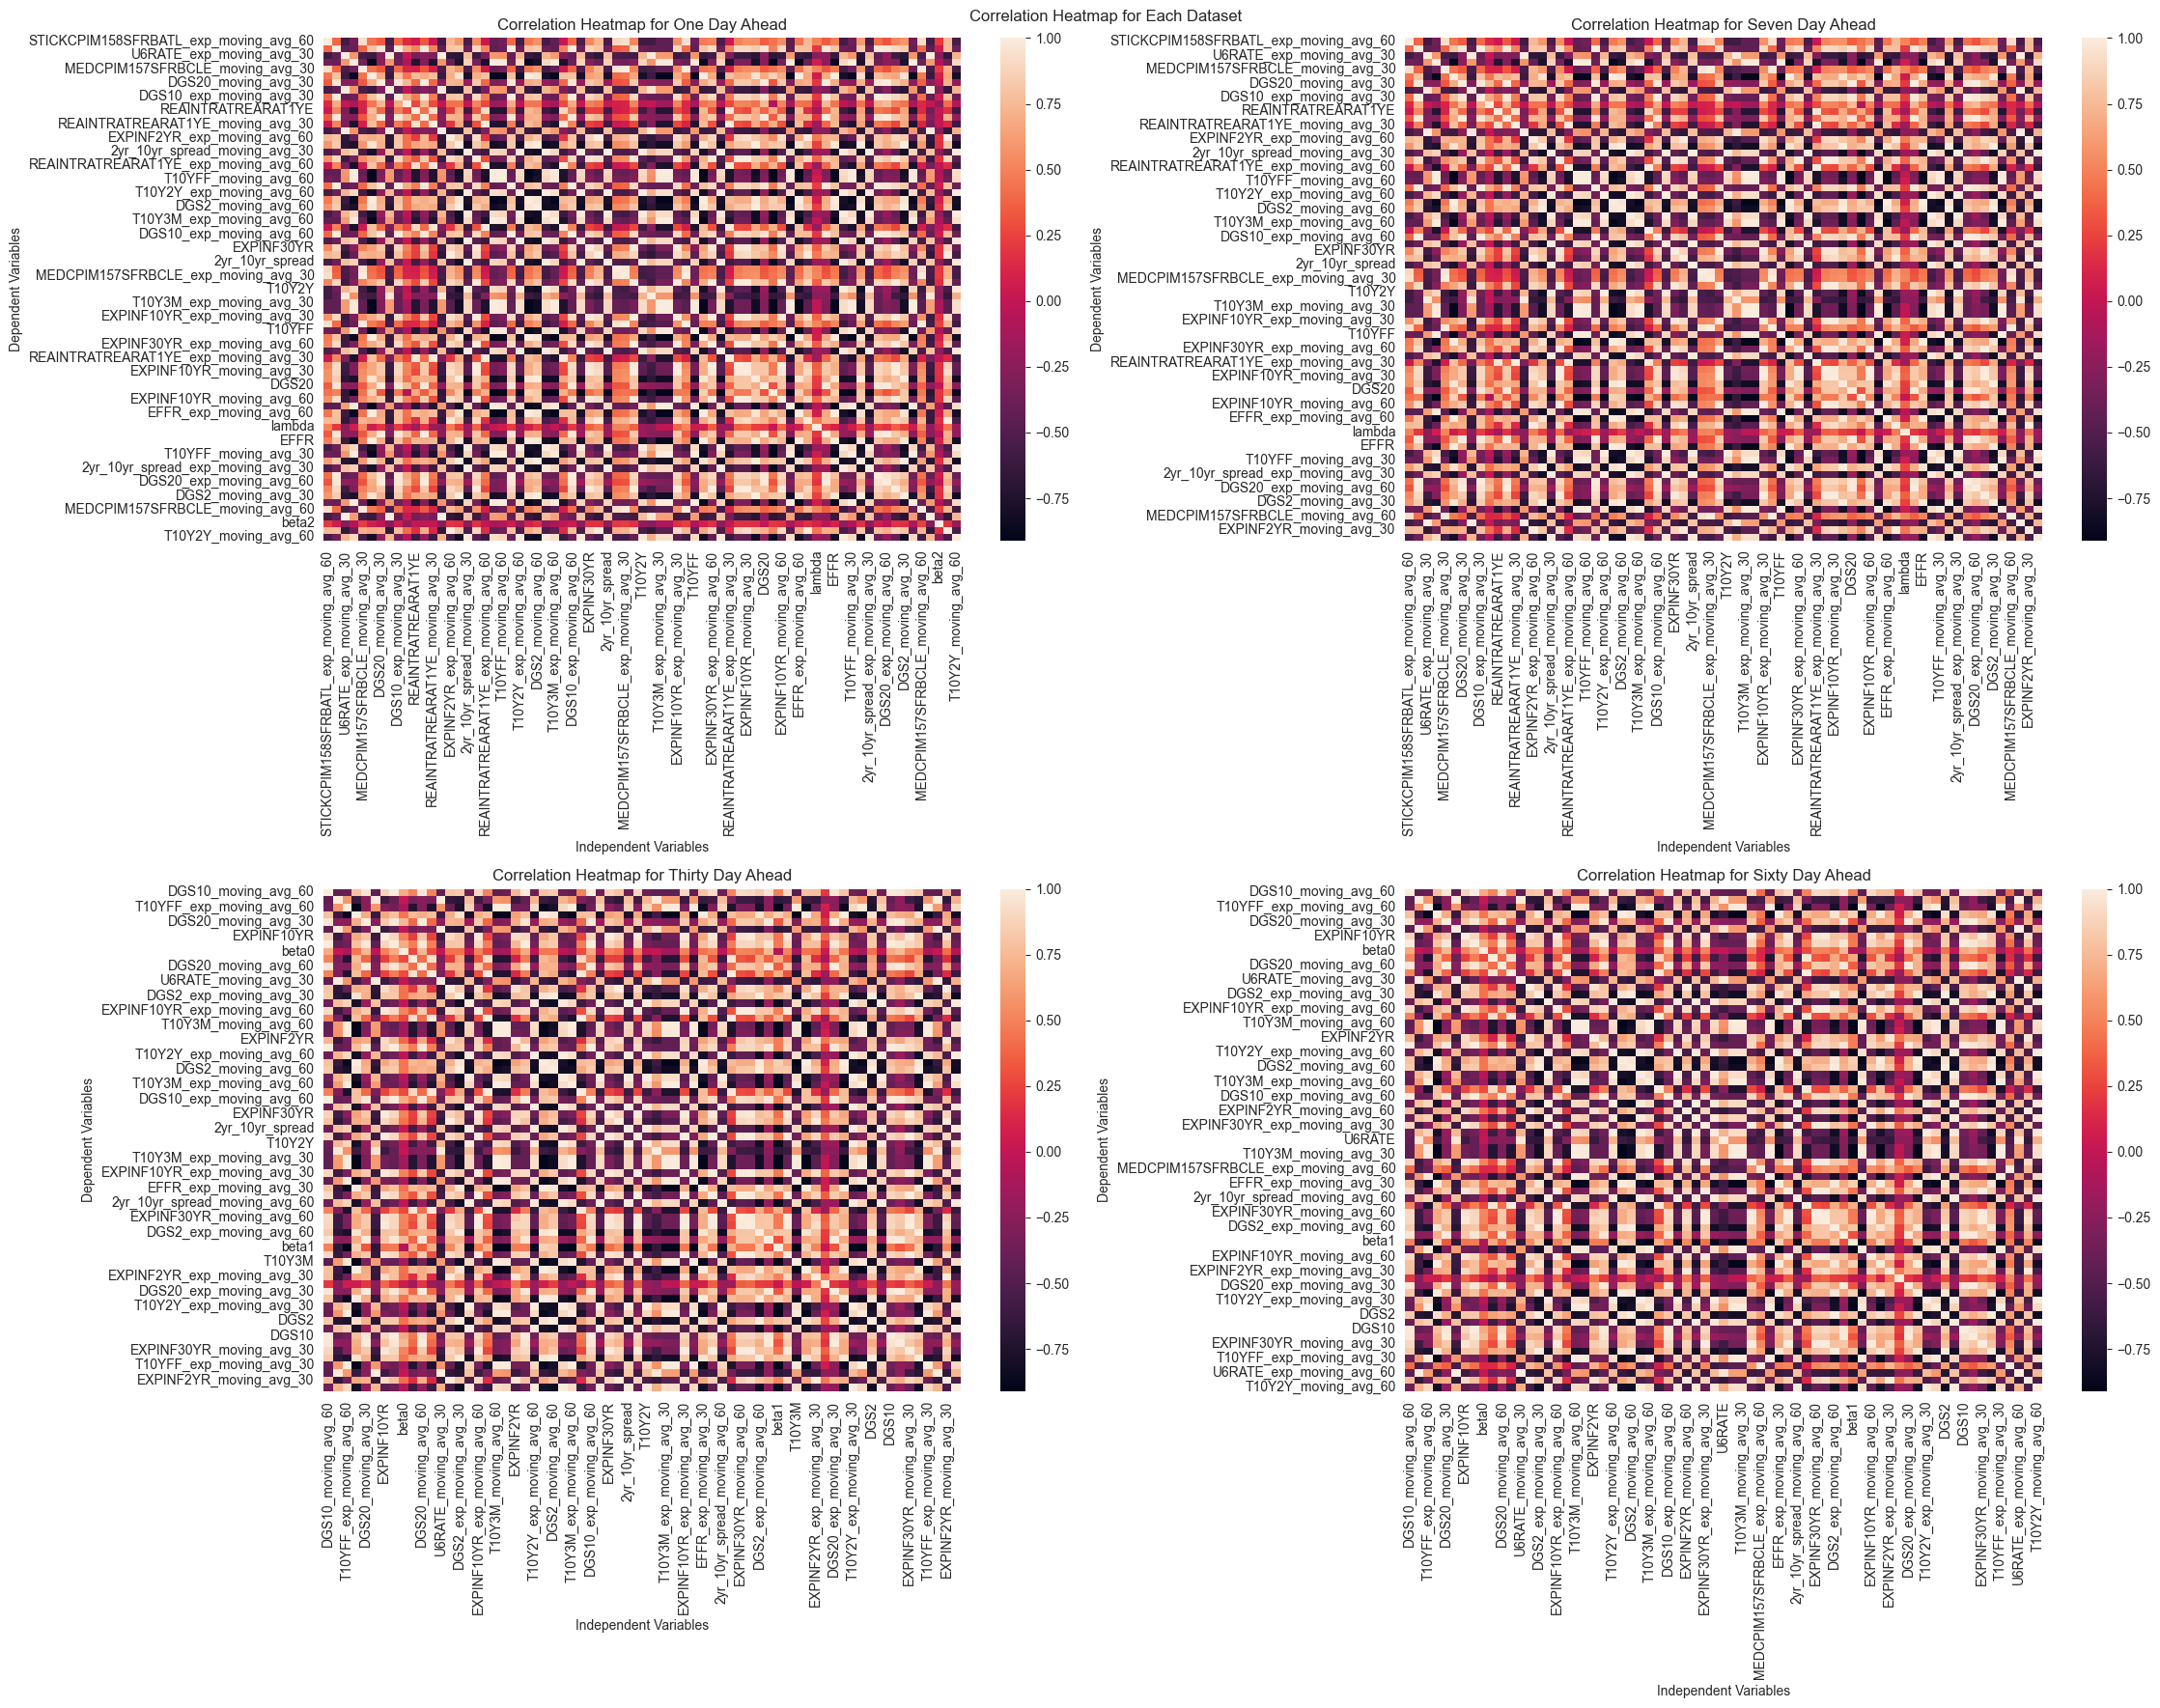

In [116]:
# plot the correlation heatmap of the for each datasets' independent variables
data_sets = [bond_yields_ns_params_shifted_1, bond_yields_ns_params_shifted_7, bond_yields_ns_params_shifted_30, bond_yields_ns_params_shifted_60]
correlated_features = [one_day_ahead_correlated_features, seven_day_ahead_correlated_features, thirty_day_ahead_correlated_features, sixty_day_ahead_correlated_features]
titles = ['One Day Ahead', 'Seven Day Ahead', 'Thirty Day Ahead', 'Sixty Day Ahead']
fig, axes = plt.subplots(2, 2, figsize=(23, 18))
axes = axes.flatten()
for i, data in enumerate(zip(data_sets, correlated_features, titles)):
    data_vals = data[0]
    ind_cols = data[1]
    title = data[2]
    sns.heatmap(data_vals[ind_cols].corr(), annot=False, ax=axes[i])
    axes[i].set_title(f'Correlation Heatmap for {title}')
    axes[i].set_xlabel('Independent Variables')
    axes[i].set_ylabel('Dependent Variables')
plt.suptitle('Correlation Heatmap for Each Dataset')
plt.tight_layout()

In [4]:
# get the avg correlation for each independent variable for each dataset
df_correlation1_avg = df_correlation1[df_correlation1['independent_variable'].isin(one_day_ahead_correlated_features)].groupby('independent_variable')['correlation'].mean().reset_index()
df_correlation7_avg = df_correlation7[df_correlation7['independent_variable'].isin(seven_day_ahead_correlated_features)].groupby('independent_variable')['correlation'].mean().reset_index()
df_correlation30_avg = df_correlation30[df_correlation30['independent_variable'].isin(thirty_day_ahead_correlated_features)].groupby('independent_variable')['correlation'].mean().reset_index()
df_correlation60_avg = df_correlation60[df_correlation60['independent_variable'].isin(sixty_day_ahead_correlated_features)].groupby('independent_variable')['correlation'].mean().reset_index()
# pivot the df correlation data so the dependent varibales values are columns, the corresponding coefficients are the column values, and is indexed by the independent variable
df_correlation1_avg = df_correlation1[df_correlation1['independent_variable'].isin(one_day_ahead_correlated_features)].pivot(index='independent_variable', columns='dependent_variable', values='correlation')
df_correlation7_avg = df_correlation7[df_correlation7['independent_variable'].isin(seven_day_ahead_correlated_features)].pivot(index='independent_variable', columns='dependent_variable', values='correlation')
df_correlation30_avg = df_correlation30[df_correlation30['independent_variable'].isin(thirty_day_ahead_correlated_features)].pivot(index='independent_variable', columns='dependent_variable', values='correlation')
df_correlation60_avg = df_correlation60[df_correlation60['independent_variable'].isin(sixty_day_ahead_correlated_features)].pivot(index='independent_variable', columns='dependent_variable', values='correlation')

# create a weighted avg columns that takes the row wise average by applying the following weights for each column, beta0 = 0.2 beta1 = 0.4 beta2 = 0.3 lambda = 0.1
weights = {'beta0': 0.2, 'beta1': 0.4, 'beta2': 0.3, 'lambda': 0.1}

df_correlation1_avg['weighted_avg'] = (
    df_correlation1_avg['beta0_future_val'] * weights['beta0'] +
    df_correlation1_avg['beta1_future_val'] * weights['beta1'] +
    df_correlation1_avg['beta2_future_val'] * weights['beta2'] +
    df_correlation1_avg['lambda_future_val'] * weights['lambda']
)

df_correlation7_avg['weighted_avg'] = (
    df_correlation7_avg['beta0_future_val'] * weights['beta0'] +
    df_correlation7_avg['beta1_future_val'] * weights['beta1'] +
    df_correlation7_avg['beta2_future_val'] * weights['beta2'] +
    df_correlation7_avg['lambda_future_val'] * weights['lambda']
)

df_correlation30_avg['weighted_avg'] = (
    df_correlation30_avg['beta0_future_val'] * weights['beta0'] +
    df_correlation30_avg['beta1_future_val'] * weights['beta1'] +
    df_correlation30_avg['beta2_future_val'] * weights['beta2'] +
    df_correlation30_avg['lambda_future_val'] * weights['lambda']
)

df_correlation60_avg['weighted_avg'] = (
    df_correlation60_avg['beta0_future_val'] * weights['beta0'] +
    df_correlation60_avg['beta1_future_val'] * weights['beta1'] +
    df_correlation60_avg['beta2_future_val'] * weights['beta2'] +
    df_correlation60_avg['lambda_future_val'] * weights['lambda']
)
df_correlation1_avg.sort_values(by='weighted_avg', ascending=False)

dependent_variable             beta0_future_val  beta1_future_val  \
independent_variable                                                
DGS2_moving_avg_60                     0.450309          0.824750   
DGS2_moving_avg_30                     0.440706          0.813872   
DGS2                                   0.426203          0.803681   
DGS2_exp_moving_avg_30                 0.429559          0.812400   
DGS2_exp_moving_avg_60                 0.430061          0.821123   
...                                         ...               ...   
2yr_10yr_spread_moving_avg_30         -0.005964         -0.864539   
T10Y2Y_exp_moving_avg_30              -0.018232         -0.870188   
T10Y2Y_moving_avg_30                  -0.039939         -0.866736   
2yr_10yr_spread_moving_avg_60         -0.023824         -0.868254   
T10Y2Y_moving_avg_60                  -0.058457         -0.870630   

dependent_variable             beta2_future_val  lambda_future_val  \
independent_variable                                                 
DGS2_moving_avg_60                     0.158828           0.225044   
DGS2_moving_avg_30                     0.160421           0.243117   
DGS2                                   0.172261           0.261298   
DGS2_exp_moving_avg_30                 0.163990           0.243213   
DGS2_exp_moving_avg_60                 0.157810           0.225192   
...                                         ...                ...   
2yr_10yr_spread_moving_avg_30         -0.232797          -0.177961   
T10Y2Y_exp_moving_avg_30              -0.217509          -0.177079   
T10Y2Y_moving_avg_30                  -0.210115          -0.178460   
2yr_10yr_spread_moving_avg_60         -0.233246          -0.169394   
T10Y2Y_moving_avg_60                  -0.210462          -0.168175   

dependent_variable             weighted_avg  
independent_variable                         
DGS2_moving_avg_60                 0.490114  
DGS2_moving_avg_30                 0.486128  
DGS2                               0.484521  
DGS2_exp_moving_avg_30             0.484390  
DGS2_exp_moving_avg_60             0.484324  
...                                     ...  
2yr_10yr_spread_moving_avg_30     -0.434644  
T10Y2Y_exp_moving_avg_30          -0.434682  
T10Y2Y_moving_avg_30              -0.435563  
2yr_10yr_spread_moving_avg_60     -0.438980  
T10Y2Y_moving_avg_60              -0.439900  

[73 rows x 5 columns]

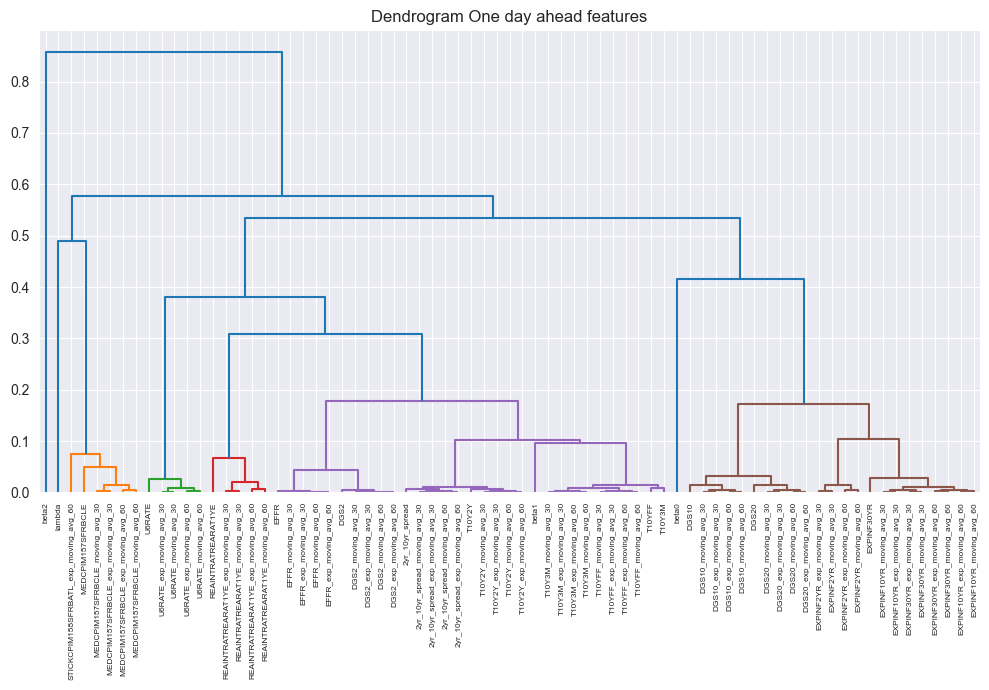

In [35]:
# get the set of uncorrelated features with the highest weighted avg
# 1. Compute correlation matrix
corr = bond_yields_ns_params_shifted_1[one_day_ahead_correlated_features].corr().abs()
# get the distance
dist = 1 - corr
dist_condensed = squareform(dist)
linkage_matrix = linkage(dist_condensed, method='average')
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, color_threshold=0.3, labels=corr.columns, leaf_rotation=90)
plt.title('Dendrogram One day ahead features')
plt.tight_layout()
plt.show()

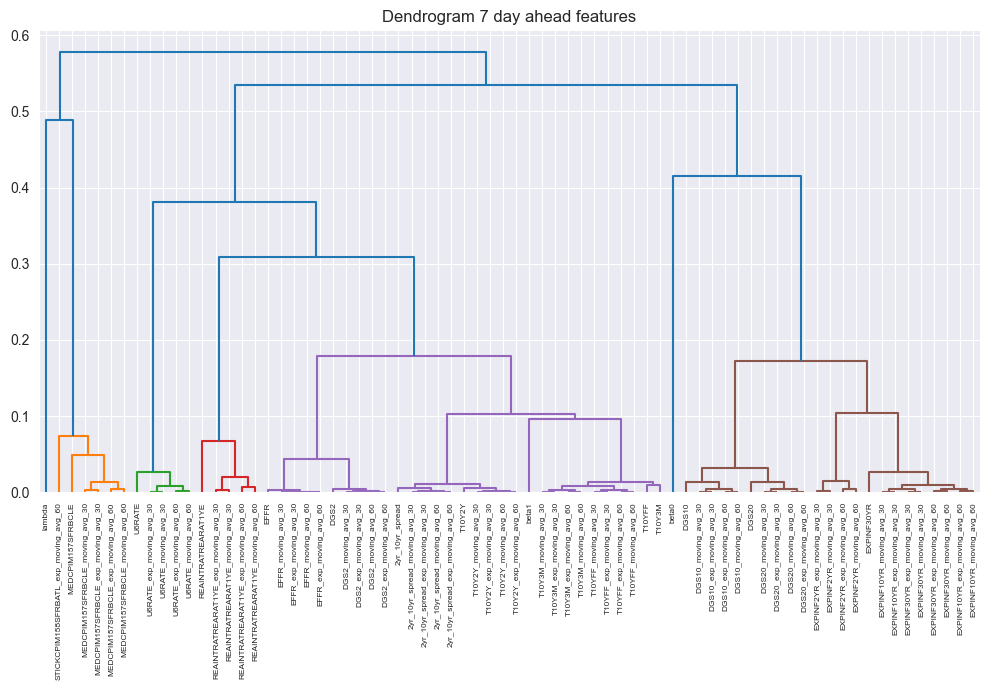

In [36]:
corr = bond_yields_ns_params_shifted_7[seven_day_ahead_correlated_features].corr().abs()
# get the distance
dist = 1 - corr
dist_condensed = squareform(dist)
linkage_matrix = linkage(dist_condensed, method='average')
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, color_threshold=0.3, labels=corr.columns, leaf_rotation=90)
plt.title('Dendrogram 7 day ahead features')
plt.tight_layout()
plt.show()

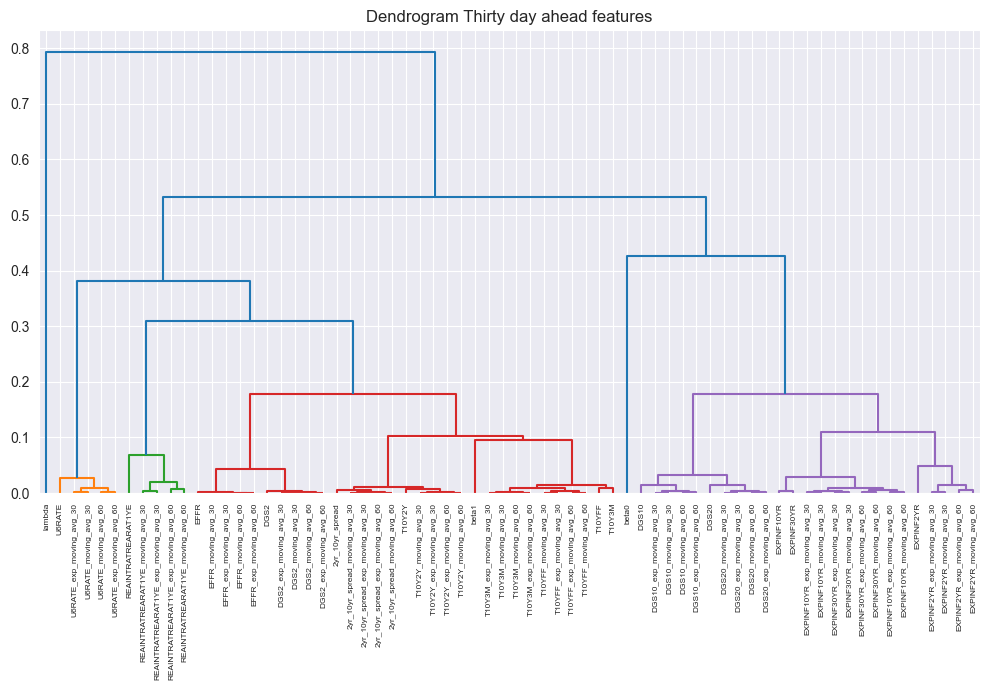

In [149]:
corr = bond_yields_ns_params_shifted_30[thirty_day_ahead_correlated_features].corr().abs()
# get the distance
dist = 1 - corr
dist_condensed = squareform(dist)
linkage_matrix = linkage(dist_condensed, method='average')
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, color_threshold=0.3, labels=corr.columns, leaf_rotation=90)
plt.title('Dendrogram Thirty day ahead features')
plt.tight_layout()
plt.show()

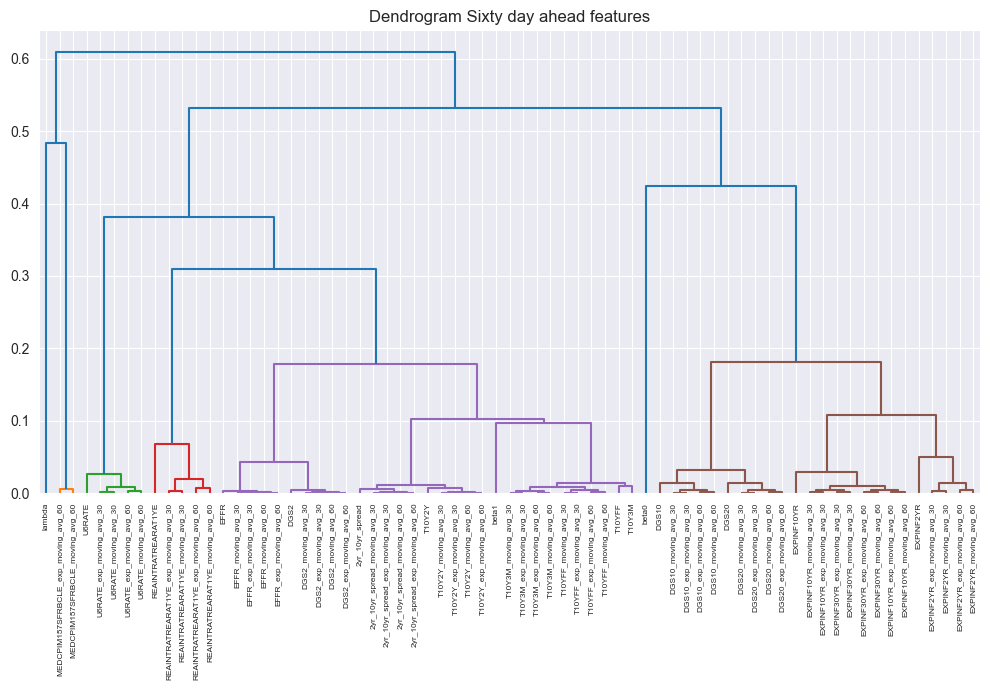

In [37]:
corr = bond_yields_ns_params_shifted_60[sixty_day_ahead_correlated_features].corr().abs()
# get the distance
dist = 1 - corr
dist_condensed = squareform(dist)
linkage_matrix = linkage(dist_condensed, method='average')
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, color_threshold=0.3, labels=corr.columns, leaf_rotation=90)
plt.title('Dendrogram Sixty day ahead features')
plt.tight_layout()
plt.show()

In [56]:
# out of the 5 groups get the features with the highest correlation
def get_correlated_clusters(df: pd.DataFrame, cols: list[str], threshold: float = 0.5) -> pd.DataFrame:
    """
    Get the clusters of correlated features. based on the specified threshold
    """
    corr = df[cols].corr().abs()
    dist = 1 - corr
    dist_condensed = squareform(dist, checks=False)
    linkage_matrix = linkage(dist_condensed, method='average')
    cluster_labels = fcluster(linkage_matrix, threshold, criterion='distance')
    return pd.DataFrame({'feature': cols, 'cluster': cluster_labels})

def feature_reduction(df1: pd.DataFrame, df2: pd.DataFrame, col_threshold: str) -> list[str]:
    """
    Get the max correlated feature in each cluster
    df1: cluster df
    df2: correlation df
    col_threshold: the threshold to use for the feature reduction in df2
    """
    grouped_features = df1.groupby('cluster')['feature'].apply(list)
    max_correlated_features = []
    for cluster, features in grouped_features.items():
        max_corr_feature = df2.loc[features][col_threshold].idxmax()
        max_correlated_features.append(max_corr_feature)
    # get the list of features not in max_correlated_features
    other_features = [feature for feature in df2.index if feature not in max_correlated_features]

    return max_correlated_features, other_features

def feature_reduction2(df1: pd.DataFrame, df2: pd.DataFrame, col_threshold: str) -> list[str]:
    """
    Get the max correlated feature in each cluster for each dependent variable
    Args:
        df1:
        df2:
        col_threshold:

    Returns:

    """
    grouped_features = df1.groupby('cluster')['feature'].apply(list)
    max_correlated_features = []
    for cluster, features in grouped_features.items():
        for dependent_variable in df2['dependent_variable'].unique():
            max_feature_indx = df2[(df2['dependent_variable'] == dependent_variable) & (df2['independent_variable'].isin(features))][col_threshold].idxmax()
            max_corr_feature = df2.loc[max_feature_indx]['independent_variable']
            max_correlated_features.append(max_corr_feature)
    # get rid of any duplicate values
    max_correlated_features = list(set(max_correlated_features))
    other_features = [feature for feature in df2.index if feature not in max_correlated_features]
    return max_correlated_features, other_features

df_cluster = get_correlated_clusters(bond_yields_ns_params_shifted_1, one_day_ahead_correlated_features, threshold=0.3)
max_correlated_features1, other_features1 = feature_reduction2(df_cluster, df_correlation1, col_threshold='correlation')
max_correlated_features1

['REAINTRATREARAT1YE_exp_moving_avg_60',
 'REAINTRATREARAT1YE_moving_avg_30',
 'MEDCPIM157SFRBCLE_exp_moving_avg_60',
 'DGS20_exp_moving_avg_30',
 'REAINTRATREARAT1YE',
 'beta2',
 'DGS2',
 'EFFR_moving_avg_60',
 'STICKCPIM158SFRBATL_exp_moving_avg_60',
 'U6RATE_exp_moving_avg_60',
 'U6RATE',
 'U6RATE_moving_avg_30',
 'EXPINF2YR_exp_moving_avg_60',
 'lambda',
 'beta0',
 'MEDCPIM157SFRBCLE_moving_avg_60',
 'beta1']

In [52]:
df_correlation60.head()
# get_correlated_clusters(bond_yields_ns_params_shifted_7, seven_day_ahead_correlated_features, threshold=0.3)
features_test = ['beta0', 'beta1', 'beta2']

max_feature_indx = df_correlation60[(df_correlation60['dependent_variable'] == 'beta0_future_val') & (df_correlation60['independent_variable'].isin(features_test))]['correlation'].idxmax()

max_corr_feature = df_correlation60.loc[max_feature_indx]['independent_variable']
df_correlation60[(df_correlation60['dependent_variable'] == 'beta0_future_val') & (df_correlation60['independent_variable'].isin(features_test))][['independent_variable', 'correlation']]

independent_variable  correlation
0                beta0     0.590112
1                beta1     0.143862
2                beta2    -0.041012

In [57]:
# get the rest of the features for the
df_cluster = get_correlated_clusters(bond_yields_ns_params_shifted_7, seven_day_ahead_correlated_features, threshold=0.3)
max_correlated_features7, other_features7 = feature_reduction2(df_cluster, df_correlation7, col_threshold='correlation')

df_cluster = get_correlated_clusters(bond_yields_ns_params_shifted_30, thirty_day_ahead_correlated_features, threshold=0.3)
max_correlated_features30, other_features30 = feature_reduction2(df_cluster, df_correlation30, col_threshold='correlation')

df_cluster = get_correlated_clusters(bond_yields_ns_params_shifted_60, sixty_day_ahead_correlated_features, threshold=0.3)
max_correlated_features60, other_features60 = feature_reduction2(df_cluster, df_correlation60, col_threshold='correlation')

titles = ['one day ahead', 'seven day ahead', 'thirty day ahead', 'sixty day ahead']
max_features_list = [max_correlated_features1, max_correlated_features7, max_correlated_features30, max_correlated_features60]
for title, features in zip(titles, max_features_list):
    print(f"{title} features: {features}\n")

one day ahead features: ['REAINTRATREARAT1YE_exp_moving_avg_60', 'REAINTRATREARAT1YE_moving_avg_30', 'MEDCPIM157SFRBCLE_exp_moving_avg_60', 'DGS20_exp_moving_avg_30', 'REAINTRATREARAT1YE', 'beta2', 'DGS2', 'EFFR_moving_avg_60', 'STICKCPIM158SFRBATL_exp_moving_avg_60', 'U6RATE_exp_moving_avg_60', 'U6RATE', 'U6RATE_moving_avg_30', 'EXPINF2YR_exp_moving_avg_60', 'lambda', 'beta0', 'MEDCPIM157SFRBCLE_moving_avg_60', 'beta1']

seven day ahead features: ['REAINTRATREARAT1YE_exp_moving_avg_60', 'DGS20', 'MEDCPIM157SFRBCLE_exp_moving_avg_30', 'MEDCPIM157SFRBCLE_exp_moving_avg_60', 'EXPINF2YR_exp_moving_avg_30', 'REAINTRATREARAT1YE', 'REAINTRATREARAT1YE_moving_avg_60', 'DGS2', 'EFFR_moving_avg_60', 'STICKCPIM158SFRBATL_exp_moving_avg_60', 'U6RATE_exp_moving_avg_60', 'U6RATE', 'EXPINF2YR_exp_moving_avg_60', 'lambda', 'beta0', 'MEDCPIM157SFRBCLE_moving_avg_60', 'beta1']

thirty day ahead features: ['REAINTRATREARAT1YE_exp_moving_avg_60', 'EXPINF30YR', 'EXPINF2YR_exp_moving_avg_30', 'REAINTRATREAR

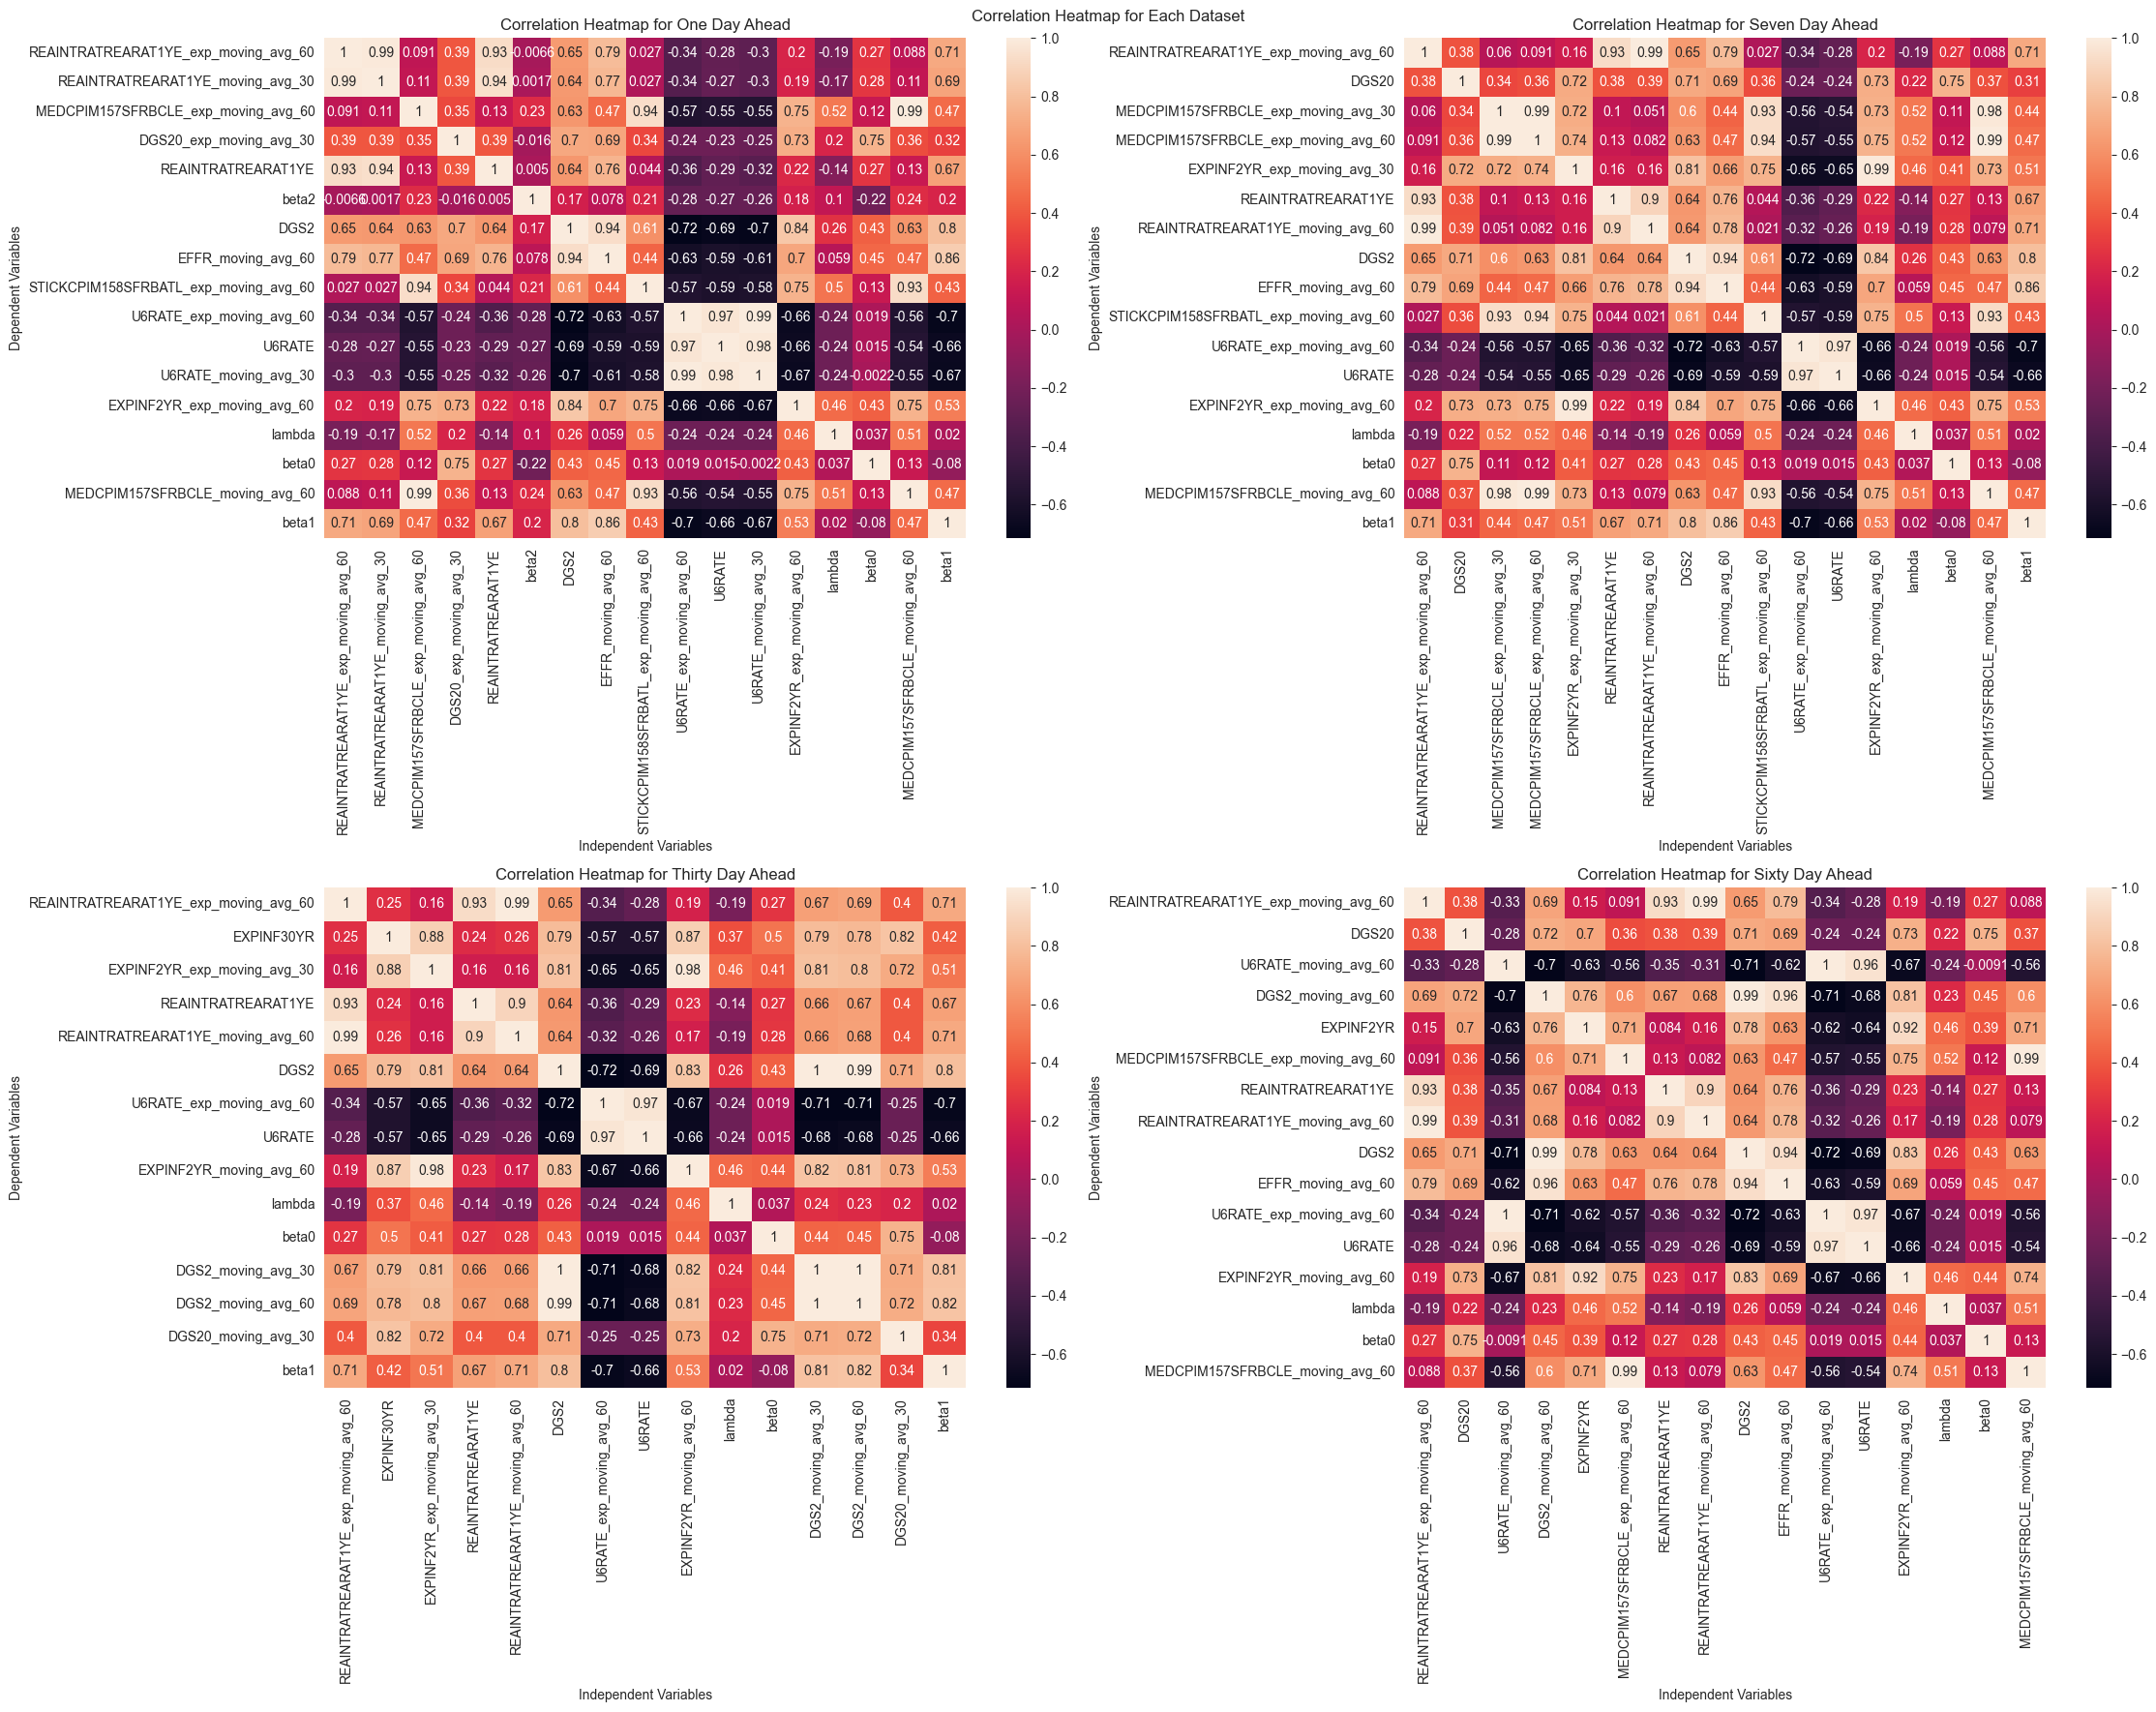

In [58]:
data_sets = [bond_yields_ns_params_shifted_1, bond_yields_ns_params_shifted_7, bond_yields_ns_params_shifted_30, bond_yields_ns_params_shifted_60]
correlated_features = [max_correlated_features1, max_correlated_features7, max_correlated_features30, max_correlated_features60]
titles = ['One Day Ahead', 'Seven Day Ahead', 'Thirty Day Ahead', 'Sixty Day Ahead']
fig, axes = plt.subplots(2, 2, figsize=(23, 18))
axes = axes.flatten()
for i, data in enumerate(zip(data_sets, correlated_features, titles)):
    data_vals = data[0]
    ind_cols = data[1]
    title = data[2]
    sns.heatmap(data_vals[ind_cols].corr(), annot=True, ax=axes[i])
    axes[i].set_title(f'Correlation Heatmap for {title}')
    axes[i].set_xlabel('Independent Variables')
    axes[i].set_ylabel('Dependent Variables')
plt.suptitle('Correlation Heatmap for Each Dataset')
plt.tight_layout()

In [59]:
# save the features as a yaml file for future use
features_selected_dict = {
    'one-day-ahead': {'max_features': max_correlated_features1, 'other_features': other_features1},
    'seven-day-ahead': {'max_features': max_correlated_features7, 'other_features': other_features7},
    'thirty-day-ahead': {'max_features': max_correlated_features30, 'other_features': other_features30},
    'sixty-day-ahead': {'max_features': max_correlated_features60, 'other_features': other_features60},
    'dependent_variables': ['beta0_future_val', 'beta1_future_val', 'beta2_future_val', 'lambda_future_val']
}

# write the dict to a yaml file
with open('data/features_selected2.yaml', 'w') as f:
    f.write(json.dumps(features_selected_dict, indent=4))
    f.close()
print(f"Features selected saved to features_selected.yaml")

Features selected saved to features_selected.yaml


In [ ]:
# plot the correlation heatmap of the for each datasets' independent variable